In [5]:
from predict import perform_inference
from rfw_loader import create_dataloaders
from train import train, write_model, save_model

import torch

In [6]:
DEVICE = 1
device = torch.device(f'cuda:{DEVICE}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [7]:
EPOCHS = 5
LEARNING_RATE = 0.01
RATIO = 0.8
BATCH_SIZE = 32
DEVICE = 1

# Train ResNet18 for RFW

In [4]:
RFW_IMAGES_DIR =  "/media/global_data/fair_neural_compression_data/datasets/RFW/data_64"
RFW_LABELS_DIR = "/media/global_data/fair_neural_compression_data/datasets/RFW/clean_metadata/numerical_labels.csv"
train_loader, test_loader = create_dataloaders(
    RFW_IMAGES_DIR, 
    RFW_LABELS_DIR, 
    BATCH_SIZE, 
    RATIO
)

## Multihead

In [13]:
import torch
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F


class MultiHeadResNet(nn.Module):
    def __init__(self, output_dims):
        super(MultiHeadResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))
        self.heads = nn.ModuleDict()
        for head, num_classes in output_dims.items():
            self.heads[head] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.resnet(x).squeeze()
        outputs = {}
        for head, head_module in self.heads.items():
            output_logits = head_module(features)
            outputs[head] = F.softmax(output_logits, dim=1)
        return outputs

In [14]:
# def train_numerical_rfw(num_epochs, lr, train_loader, device):
num_epochs = 5
lr = 0.01
output_dims = {
    'skin_type': 6,
    'eye_type': 2,
    'nose_type': 2,
    'lip_type': 2,
    'hair_type': 4,
    'hair_color': 5
}

model = MultiHeadResNet(output_dims).to(device)

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def train_numerical_rfw(num_epochs, lr, train_loader, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        running_loss = 0.0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for inputs, targets, races in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = 0
                for i, head in enumerate(outputs):
                    loss += criterion(outputs[head], targets[:, i].to(torch.int64))
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                avg_loss = running_loss / ((pbar.n + 1) * len(inputs))  # Compute average loss
                pbar.set_postfix(loss=avg_loss)
                pbar.update(1)
    return model

In [8]:
model = train_numerical_rfw(10, LEARNING_RATE, train_loader, device)

Epoch 10/10: 100%|██████████| 1016/1016 [00:46<00:00, 22.08it/s, loss=30.5]


In [9]:
save_model(model, 'models', 'RFW_numerical_all_labels_resnet18')

Writing Model
Model Saved


# Plot Skintype Images

In [ ]:
import pandas as pd
rfw_labels = pd.read_csv('/media/global_data/fair_neural_compression_data/datasets/RFW/clean_metadata/clean.csv')
rfw_labels.head()

,Unnamed: 0,File,Class_ID,skintype_type1,skintype_type2,skintype_type3,skintype_type4,skintype_type5,skintype_type6,lips_big,...,eye_normal,hairtype_bald,hairtype_curly,hairtype_straight,hairtype_wavy,haircolor_black,haircolor_blonde,haircolor_brown,haircolor_gray,haircolor_red
0,0,m.011y5k_0003.png,African/m.011y5k,0,0,0,0,0,1,1,...,1,0,1,0,0,1,0,0,0,0
1,1,m.011y5k_0004.png,African/m.011y5k,0,0,0,0,0,1,1,...,1,0,1,0,0,1,0,0,0,0
2,2,m.011y5k_0002.png,African/m.011y5k,0,0,0,0,0,1,1,...,1,0,1,0,0,1,0,0,0,0
3,3,m.011y5k_0001.png,African/m.011y5k,0,0,0,0,0,1,1,...,1,0,1,0,0,1,0,0,0,0
4,4,m.01257s_0002.png,African/m.01257s,0,0,0,0,1,0,1,...,1,0,1,0,0,1,0,0,0,0


In [ ]:
def select_random_images(df, num_images_per_type=6):
    selected_images = []
    for skintype_col in ['skintype_type1', 'skintype_type2', 'skintype_type3', 'skintype_type4', 'skintype_type5', 'skintype_type6']:
        skin_type = skintype_col.split('_')[-1]  # Extract the skin type from the column name
        # Select images for each skin type
        images = df[df[skintype_col] == 1].sample(num_images_per_type)
        selected_images.extend([[skin_type, class_id, image_path] for class_id, image_path in images[['Class_ID', 'File']].values.tolist()])
    return selected_images

random_images: [['type1', 'Caucasian/m.09wsvh', 'm.09wsvh_0004.png'], ['type1', 'Caucasian/m.09zmys', 'm.09zmys_0003.png'], ['type1', 'Caucasian/m.09pgdh', 'm.09pgdh_0001.png'], ['type1', 'Caucasian/m.0bmjwhg', 'm.0bmjwhg_0001.png']]


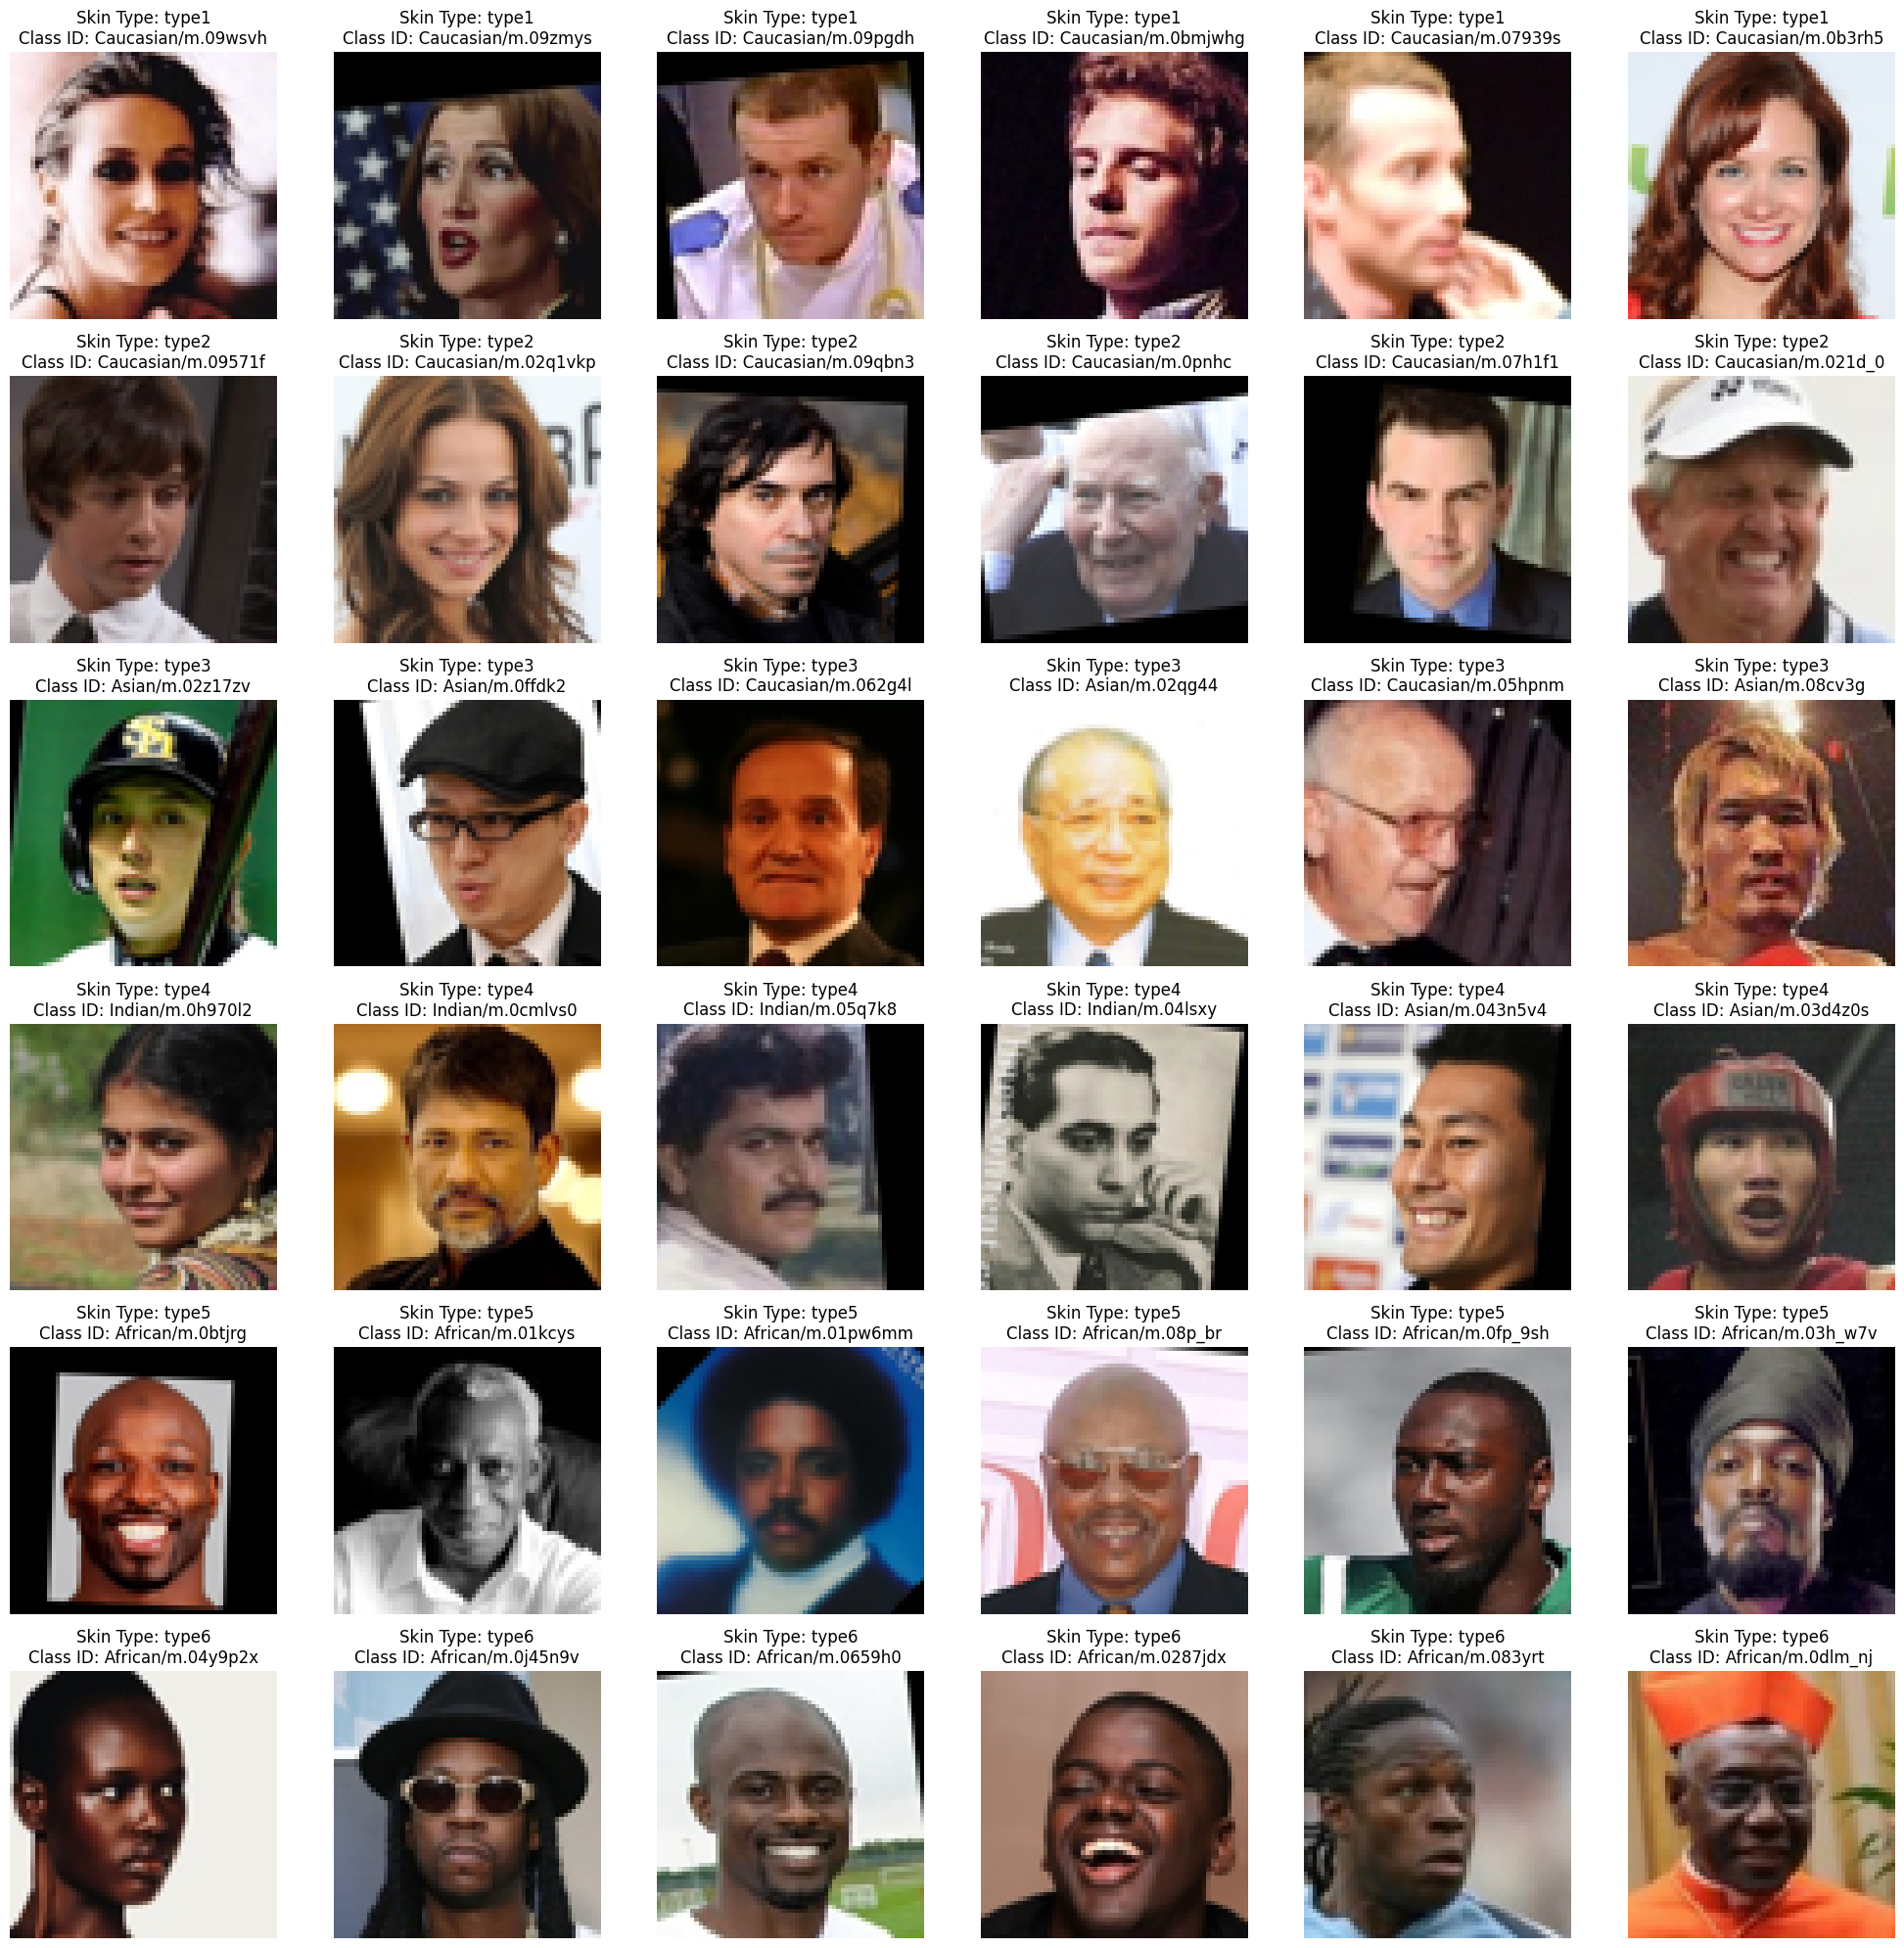

In [ ]:
import matplotlib.pyplot as plt
random_images = select_random_images(rfw_labels)
print(f'random_images: {random_images[:4]}')
num_rows = 6
num_cols = 6
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i, (skin_type, class_id, image_path) in enumerate(random_images):
    row = i // num_cols
    col = i % num_cols
    img = plt.imread(f'{RFW_IMAGES_DIR}/{class_id}/{image_path}')
    axs[row, col].imshow(img)
    axs[row, col].set_title(f"Skin Type: {skin_type}\nClass ID: {class_id}")
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

# Test Model (Race Based)

In [20]:
import torch
# model_path = 'models/RFW_numerical_no_skin_resnet18_2024-05-06_16-07-26.pth'
model_path = 'models/RFW_numerical_all_labels_resnet18_2024-05-07_13-45-45.pth'
model = torch.load(model_path)

In [21]:
# MODEL_NAME = 'RFW_numerical_no_skin_resnet18_2024-05-06_16-07-26'
model_name = 'RFW_numerical_all_labels_resnet18_2024-05-07_13-45-45'

In [22]:
train_loader, test_loader = create_dataloaders(
    "/media/global_data/fair_neural_compression_data/datasets/RFW/data_64", 
    "/media/global_data/fair_neural_compression_data/datasets/RFW/clean_metadata/numerical_labels.csv",
    BATCH_SIZE, 
    RATIO
)

In [23]:
from tqdm import tqdm
import numpy as np

def save_race_based_predictions(
        model, 
        model_name, 
        dataloader, 
        device, 
        prediction_save_dir,
        save_labels=False
    ):
    all_predictions = {'Indian': {head: torch.tensor([]) for head in model.heads.keys()}, 
                       'Caucasian': {head: torch.tensor([]) for head in model.heads.keys()}, 
                       'Asian': {head: torch.tensor([]) for head in model.heads.keys()},  
                       'African': {head: torch.tensor([]) for head in model.heads.keys()}}
    all_labels = {'Indian': {head: torch.tensor([]) for head in model.heads.keys()}, 
                  'Caucasian': {head: torch.tensor([]) for head in model.heads.keys()}, 
                  'Asian': {head: torch.tensor([]) for head in model.heads.keys()}, 
                  'African': {head: torch.tensor([]) for head in model.heads.keys()}}
    
    print(f'prediction_save_dir: {prediction_save_dir}')
    dataloader = tqdm(dataloader, desc="Getting Predictions", unit="batch")
    model.eval()
    with torch.no_grad():
        for _, data in enumerate(dataloader):
            inputs, labels, race = data
            race = np.array(race)

            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            for i, (head, predictions) in enumerate(outputs.items()):
                head_preds = predictions.argmax(dim=1).cpu()

                for race_label in all_labels:
                    race_indices = np.array((race == race_label).nonzero()[0])
                    race_predictions = head_preds[race_indices]
                    race_labels = labels[:, i][race_indices]
                
                    all_predictions[race_label][head] = torch.cat((all_predictions[race_label][head], race_predictions.to('cpu')), dim=0)
                    all_labels[race_label][head] = torch.cat((all_labels[race_label][head], race_labels.to('cpu')), dim=0)

    for race_label in all_labels:
        for category in all_labels[race_label]:
            torch.save(all_predictions[race_label][category], f'{prediction_save_dir}/{model_name}_{race_label}_{category}_predictions.pt')
            if save_labels:
                torch.save(all_labels[race_label][category], f'{prediction_save_dir}/{model_name}_{race_label}_{category}_labels.pt')

    return all_predictions, all_labels


In [24]:
all_predictions, all_labels = save_race_based_predictions(model,
                                                model_name,
                                                test_loader, 
                                                device, 
                                                'results/RFW/predictions',
                                            )

prediction_save_dir: results/RFW/predictions


Getting Predictions: 100%|██████████| 254/254 [00:09<00:00, 27.80batch/s]


In [21]:
model_name

'RFW_numerical_all_labels_resnet18_2024-05-07_13-45-45'

## Get baseline results 

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

all_baseline_results = {}
for race in all_predictions:
    all_baseline_results[race] = {}
    for category in all_predictions[race]:
        all_baseline_results[race][category] = {}
        
        preds = all_predictions[race][category]
        labels = all_labels[race][category]
        all_baseline_results[race][category]['accuracy'] = accuracy_score(labels, preds)
        all_baseline_results[race][category]['precision'] = precision_score(labels, preds, average='weighted')
        all_baseline_results[race][category]['recall'] = recall_score(labels, preds, average='weighted')
        all_baseline_results[race][category]['f1'] = f1_score(labels, preds, average='weighted')
        

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [27]:
all_baseline_results

{'Indian': {'skin_type': {'accuracy': 0.679047619047619,
   'precision': 0.6474606247828489,
   'recall': 0.679047619047619,
   'f1': 0.6606631379350829},
  'eye_type': {'accuracy': 0.6138095238095238,
   'precision': 0.6116993816508485,
   'recall': 0.6138095238095238,
   'f1': 0.6053585558380526},
  'nose_type': {'accuracy': 0.6619047619047619,
   'precision': 0.6647105387165856,
   'recall': 0.661904761904762,
   'f1': 0.6630690322101119},
  'lip_type': {'accuracy': 0.9852380952380952,
   'precision': 0.991132595886526,
   'recall': 0.9852380952380952,
   'f1': 0.9881227164164529},
  'hair_type': {'accuracy': 0.61,
   'precision': 0.39145208422792943,
   'recall': 0.61,
   'f1': 0.4767798905351143},
  'hair_color': {'accuracy': 0.6319047619047619,
   'precision': 0.4973618314964351,
   'recall': 0.6319047619047619,
   'f1': 0.5547625600708661}},
 'Caucasian': {'skin_type': {'accuracy': 0.4116758933064922,
   'precision': 0.2430446258281385,
   'recall': 0.4116758933064922,
   'f1': 

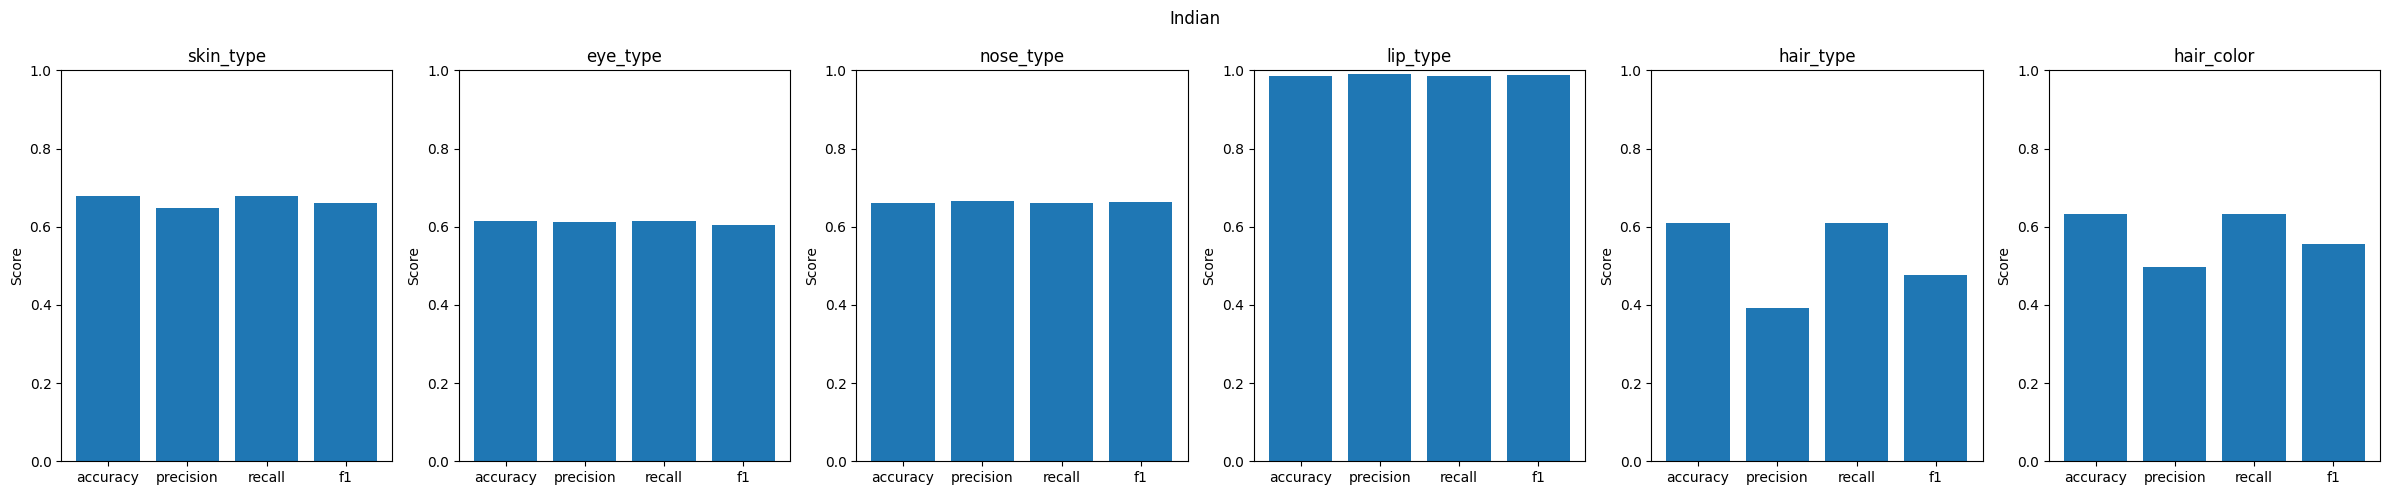

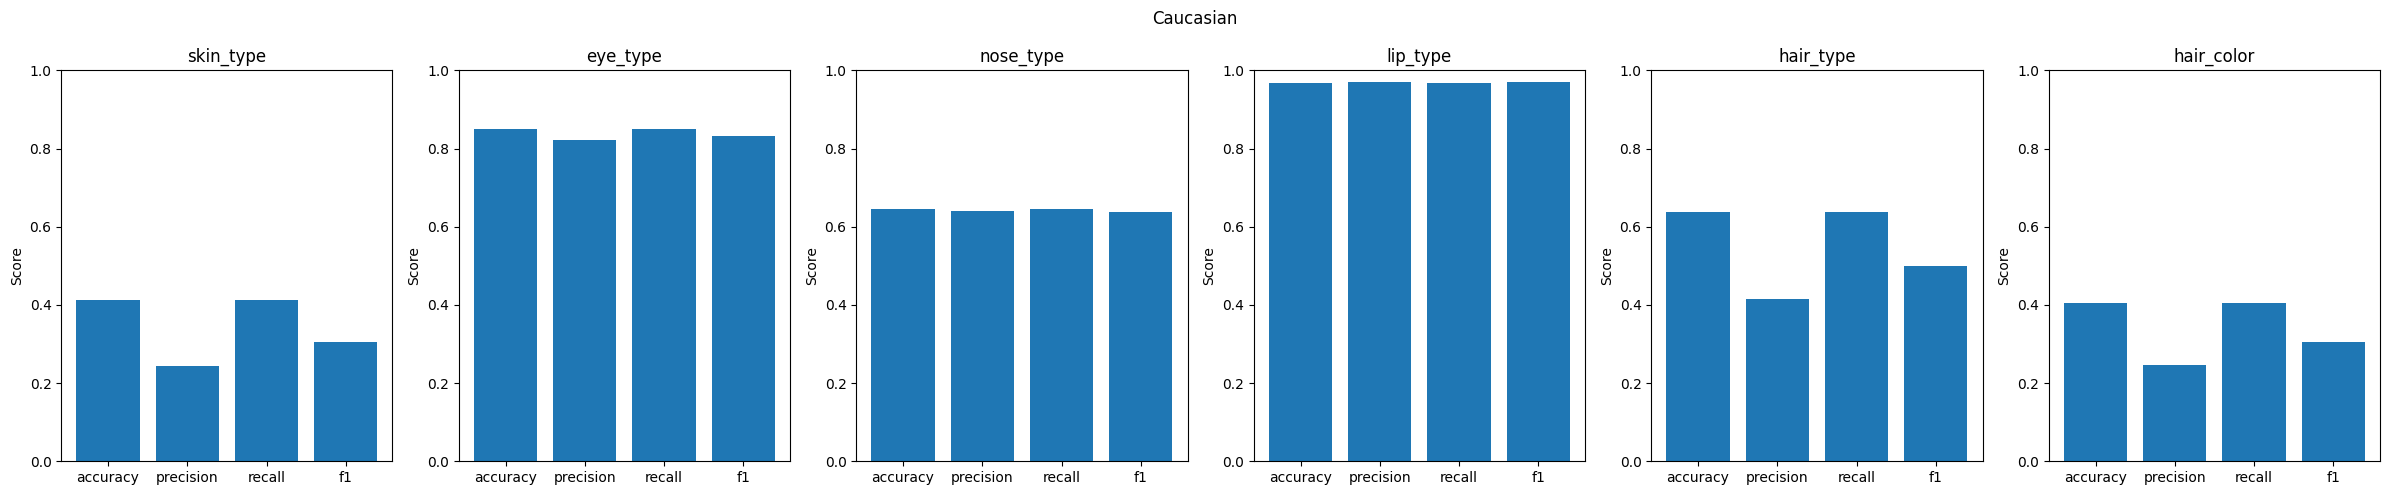

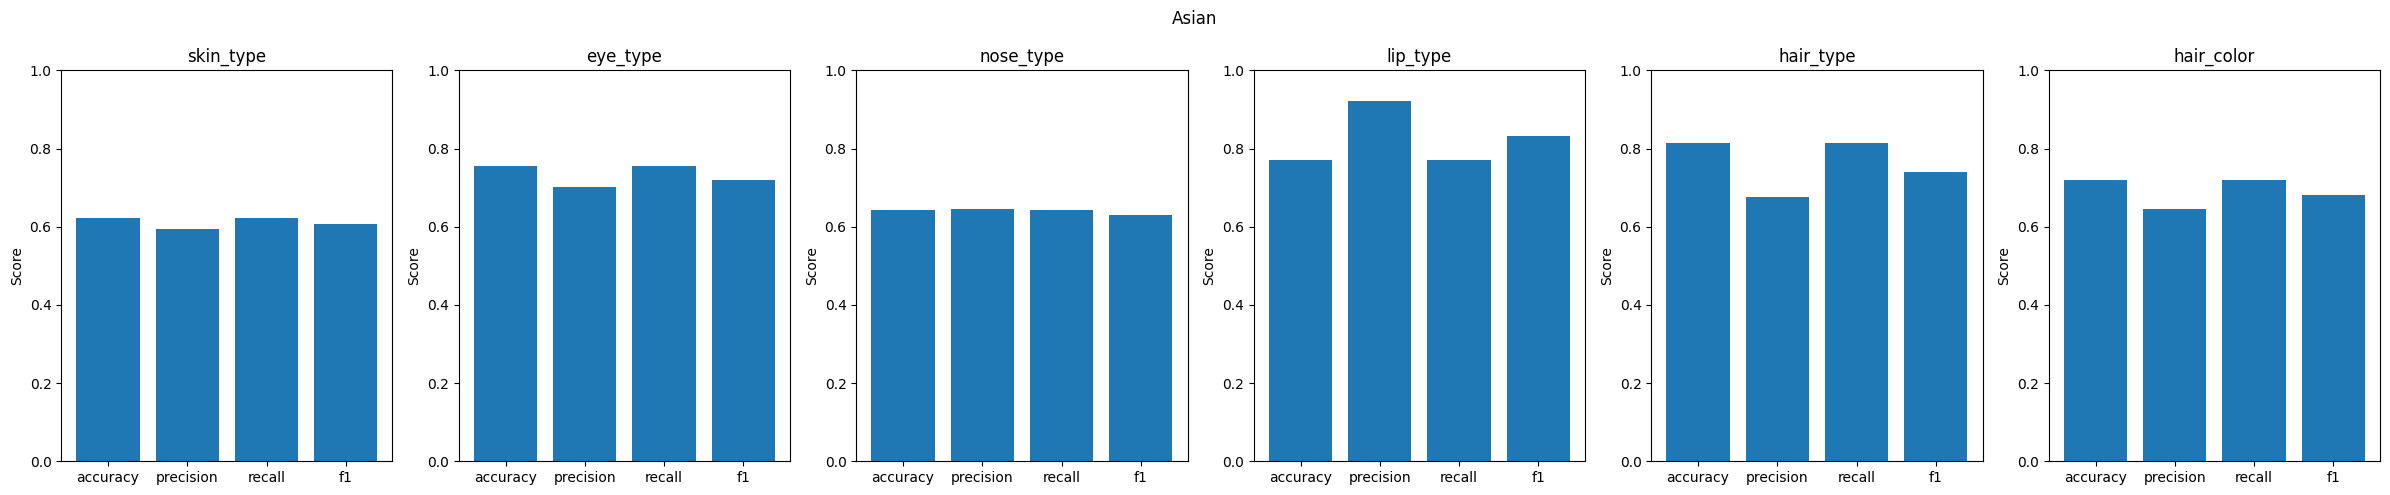

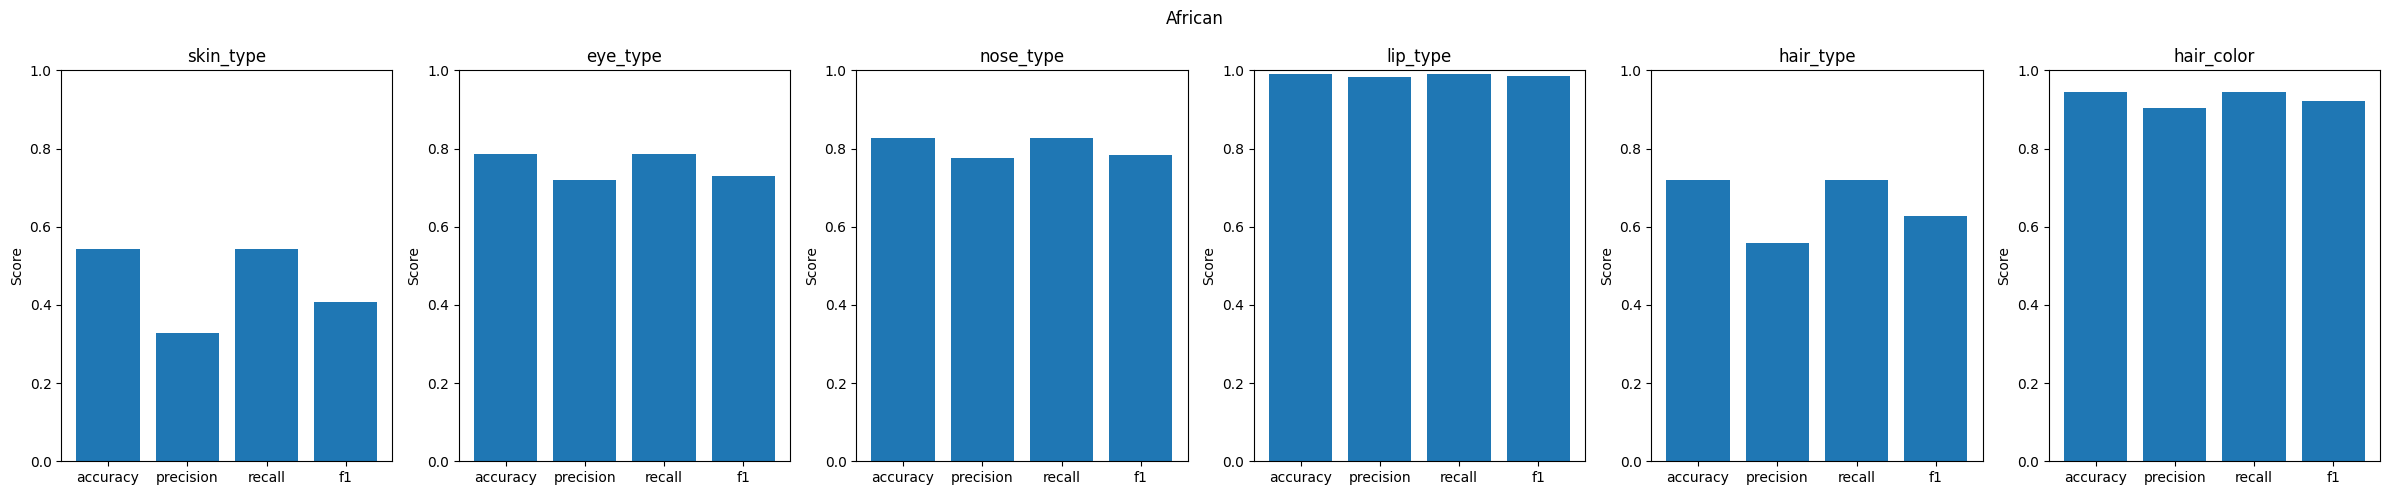

In [28]:
import matplotlib.pyplot as plt

for race in all_baseline_results:
    
    fig, axs = plt.subplots(1, len(all_baseline_results['Indian']), figsize=(24, 5))
    for i, (category, metrics) in enumerate(all_baseline_results[race].items()):
        axs[i].bar(metrics.keys(), metrics.values())
        axs[i].set_title(category)
        axs[i].set_ylabel('Score')
        axs[i].set_ylim(0, 1)  # Limit y-axis to range [0, 1] for better visualization

    # plt.savefig(f'results/RFW/plots/baselines/baseline_{race}_results.png')
    plt.suptitle(race)
    plt.tight_layout()
    plt.show()

In [51]:
for i, race in enumerate(races):
    print(f'{race} count: {all_labels[race].shape[0]}')
    for category, indices in category_indecies.items():
        preds = all_predictions[race][:, indices]
        num_zeros = torch.sum(torch.all(preds == 0, dim=1)).item()
        print(f'# of all zeros in {race}, {category} : {num_zeros}')

Asian count: 1924
# of all zeros in Asian, skin : 242
# of all zeros in Asian, lips : 0
# of all zeros in Asian, nose : 59
# of all zeros in Asian, eye : 0
# of all zeros in Asian, hair_type : 128
# of all zeros in Asian, hair_color : 327
African count: 2111
# of all zeros in African, skin : 391
# of all zeros in African, lips : 3
# of all zeros in African, nose : 0
# of all zeros in African, eye : 3
# of all zeros in African, hair_type : 361
# of all zeros in African, hair_color : 35
Indian count: 2100
# of all zeros in Indian, skin : 763
# of all zeros in Indian, lips : 1
# of all zeros in Indian, nose : 18
# of all zeros in Indian, eye : 0
# of all zeros in Indian, hair_type : 558
# of all zeros in Indian, hair_color : 599
Caucasian count: 1987
# of all zeros in Caucasian, skin : 824
# of all zeros in Caucasian, lips : 0
# of all zeros in Caucasian, nose : 32
# of all zeros in Caucasian, eye : 0
# of all zeros in Caucasian, hair_type : 379
# of all zeros in Caucasian, hair_color : 1

In [47]:
rfw_baseline_results

{'accuracy': {'skin': 0.3064922094345093,
  'lips': 0.8621037006378174,
  'nose': 0.6391544938087463,
  'eye': 0.9084046483039856,
  'hair_type': 0.5304479002952576,
  'hair_color': 0.18067438900470734},
 'precision': {},
 'recall': {},
 'f1': {}}

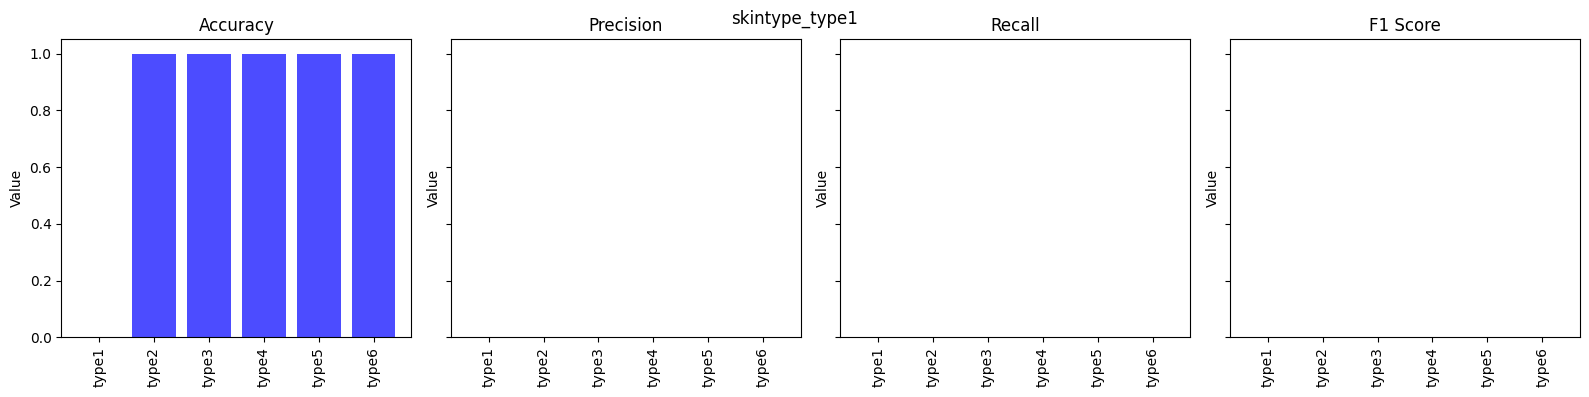

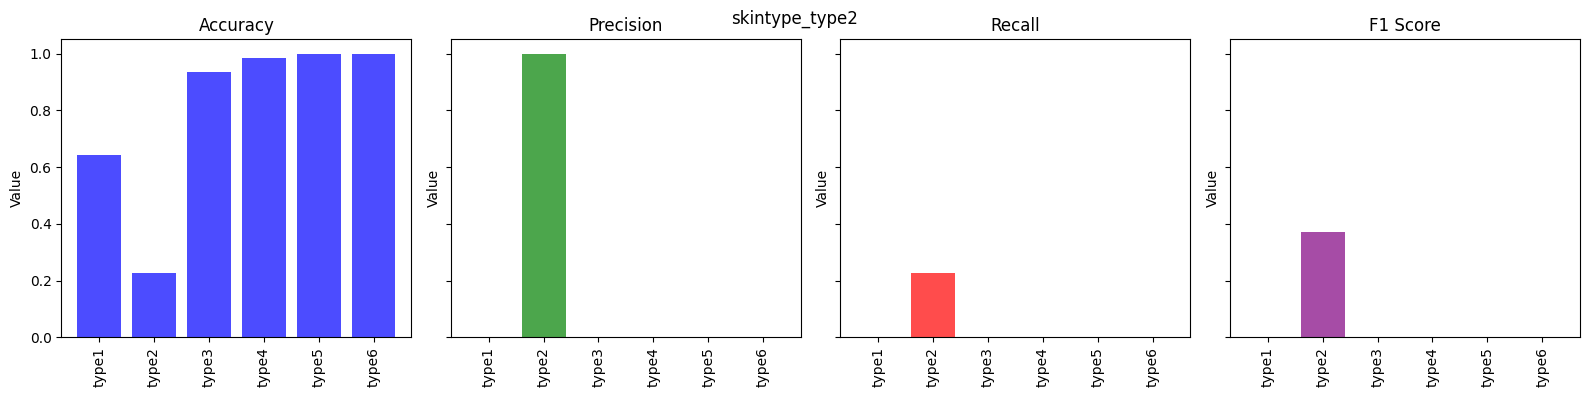

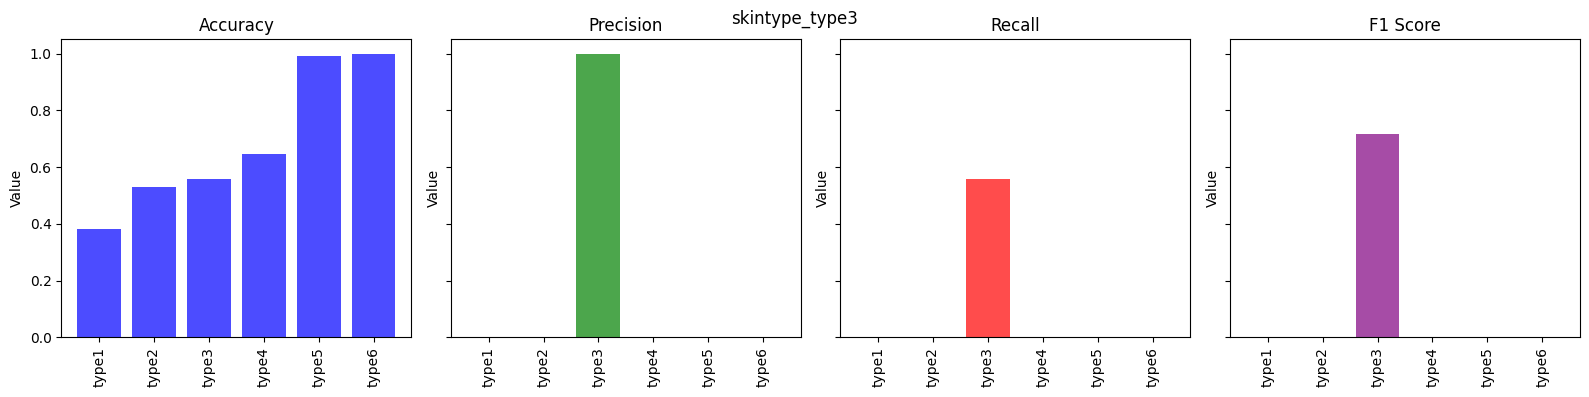

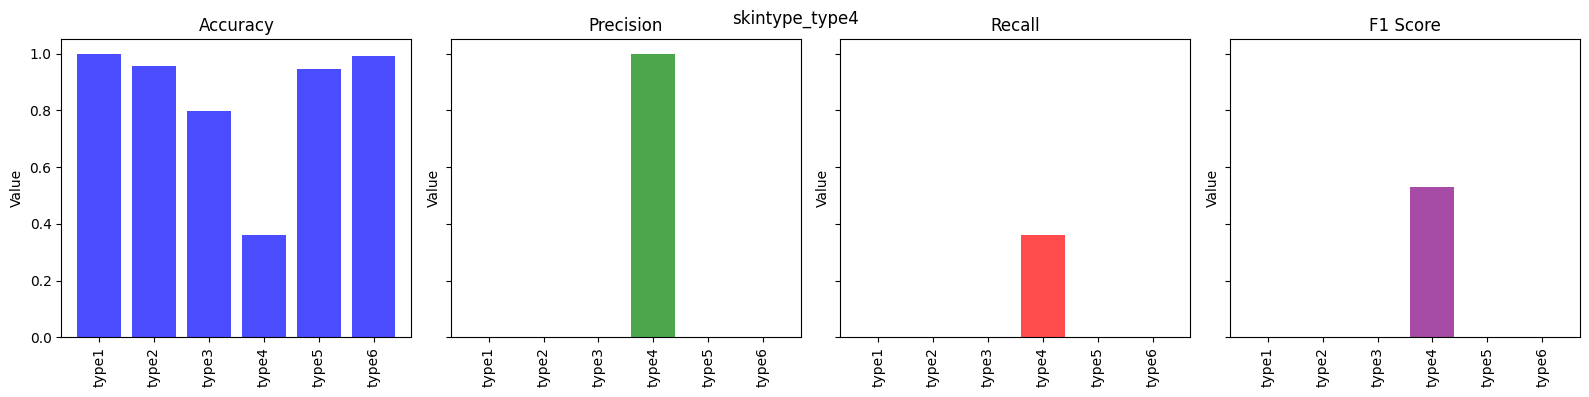

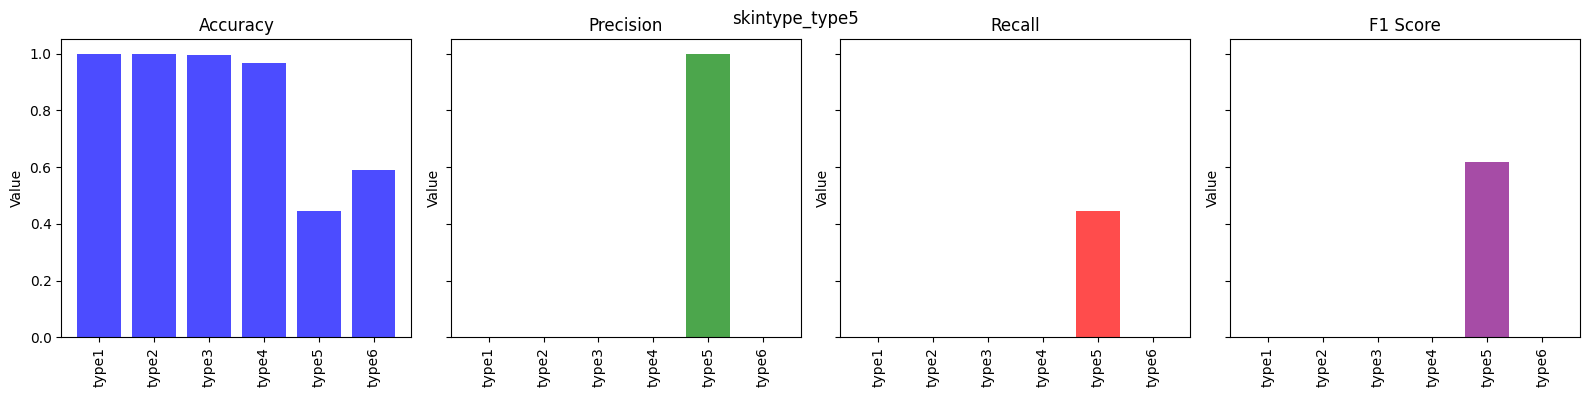

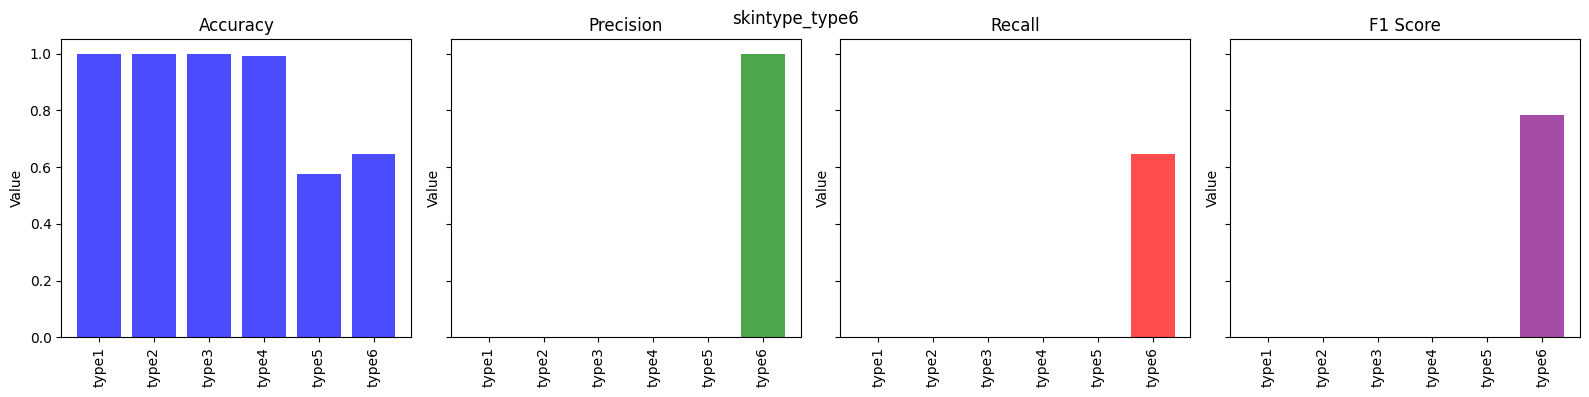

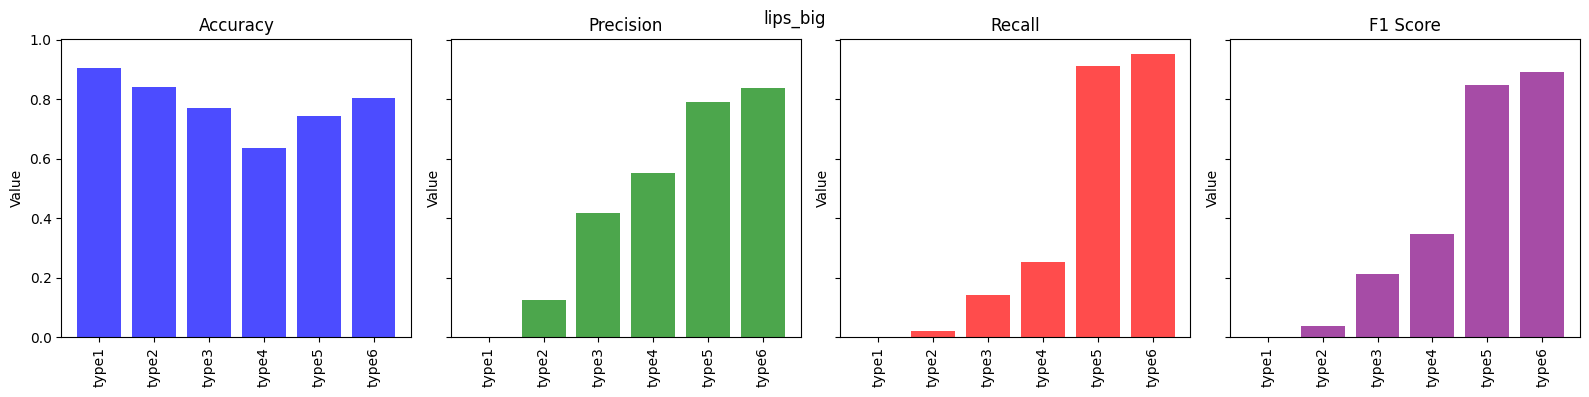

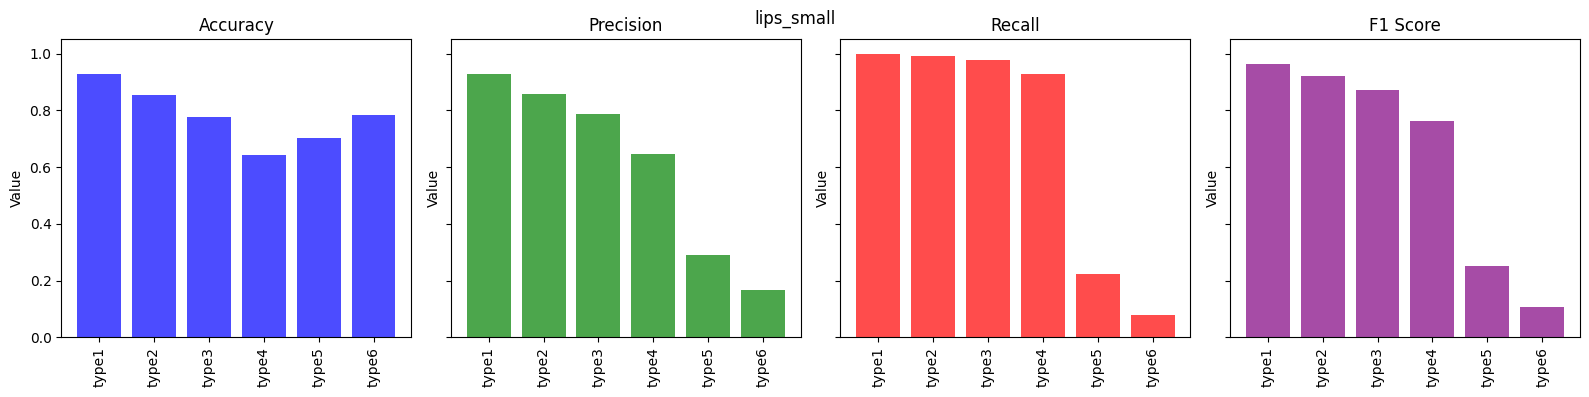

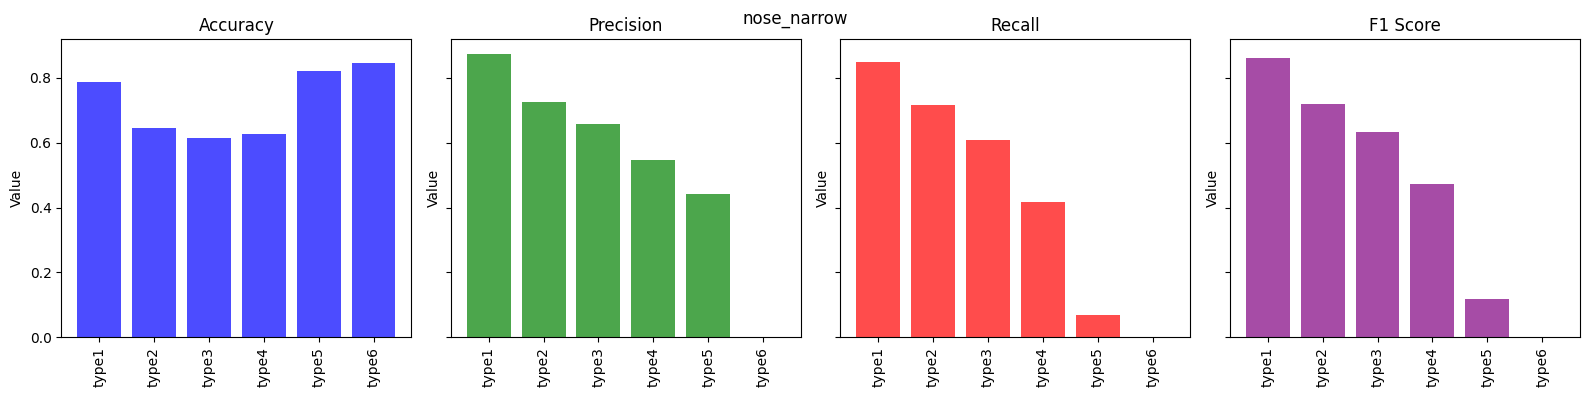

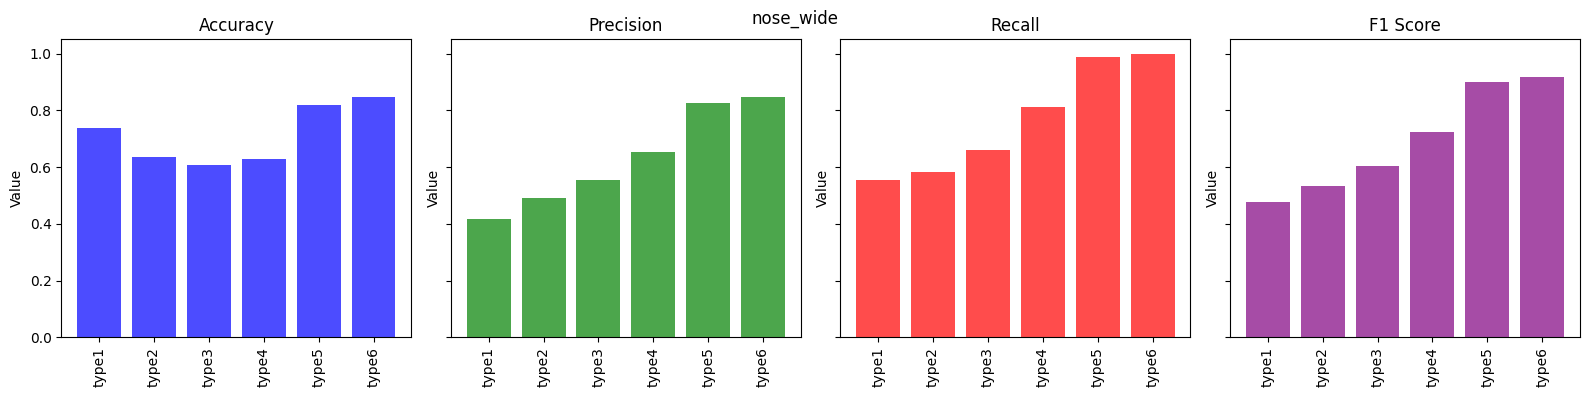

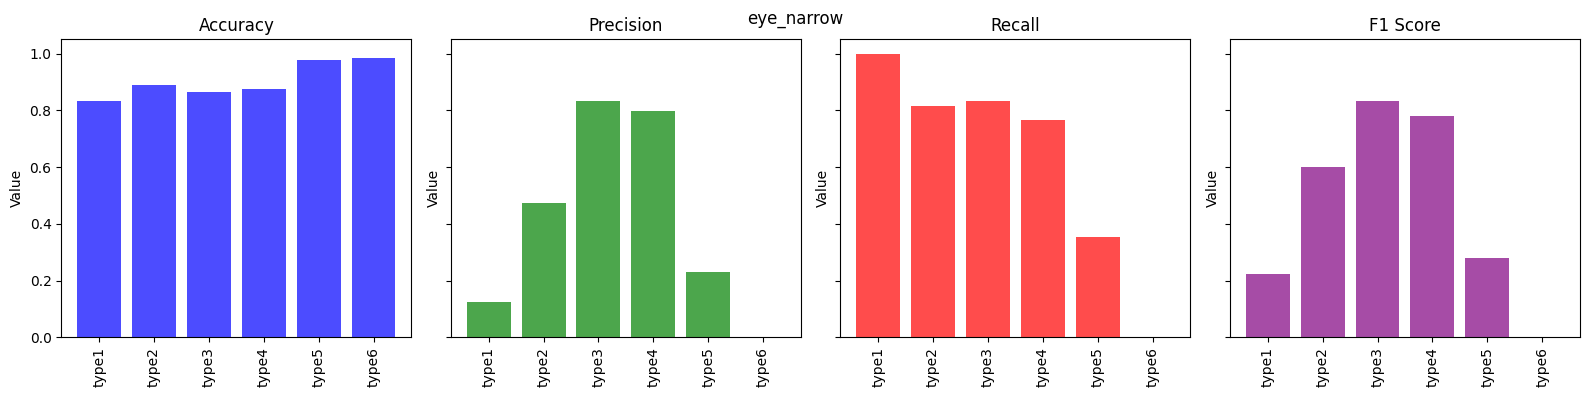

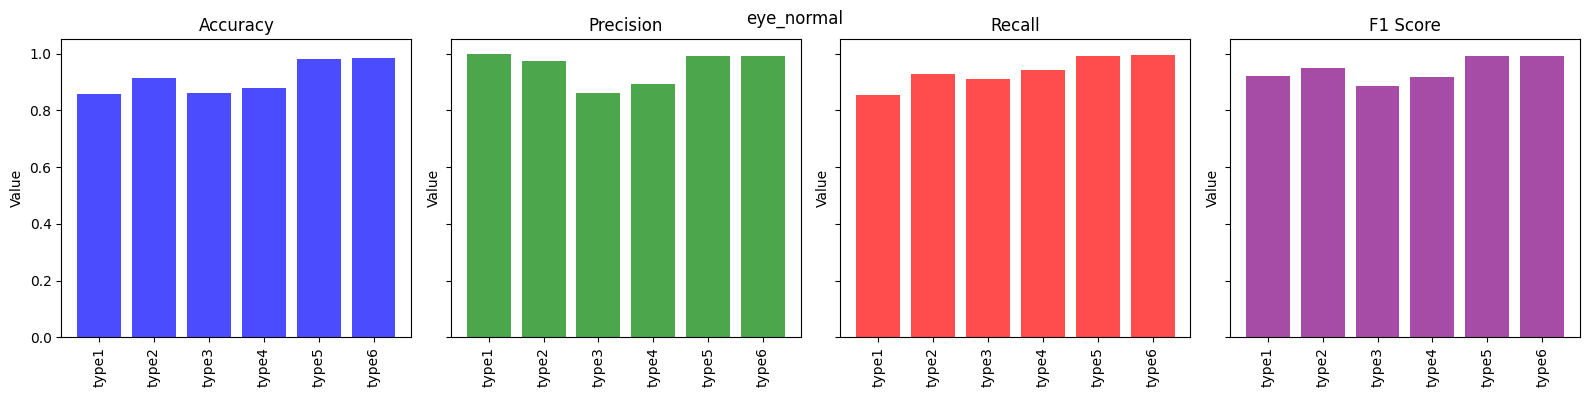

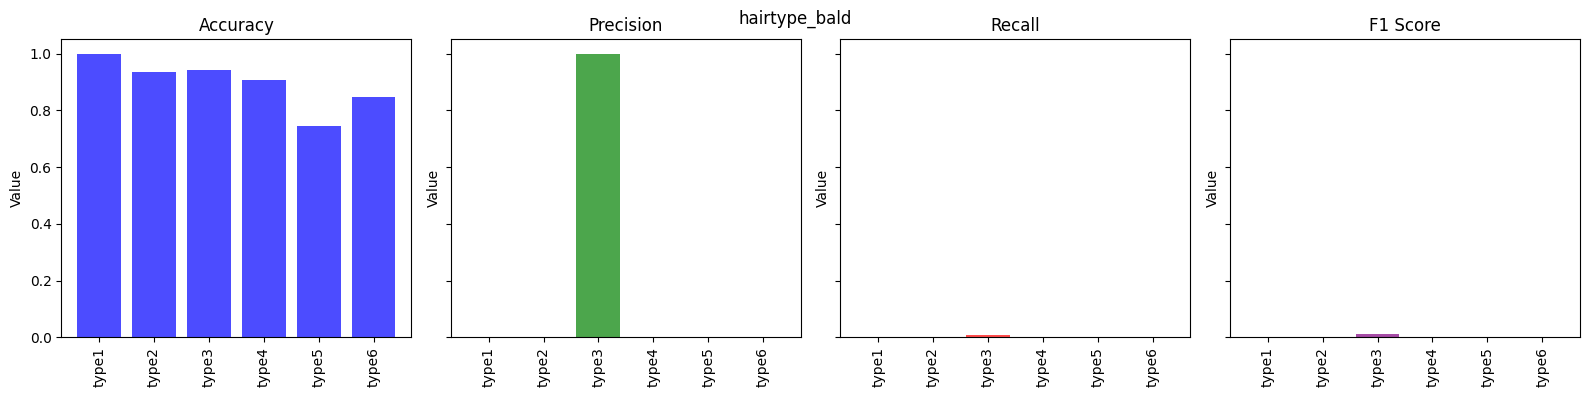

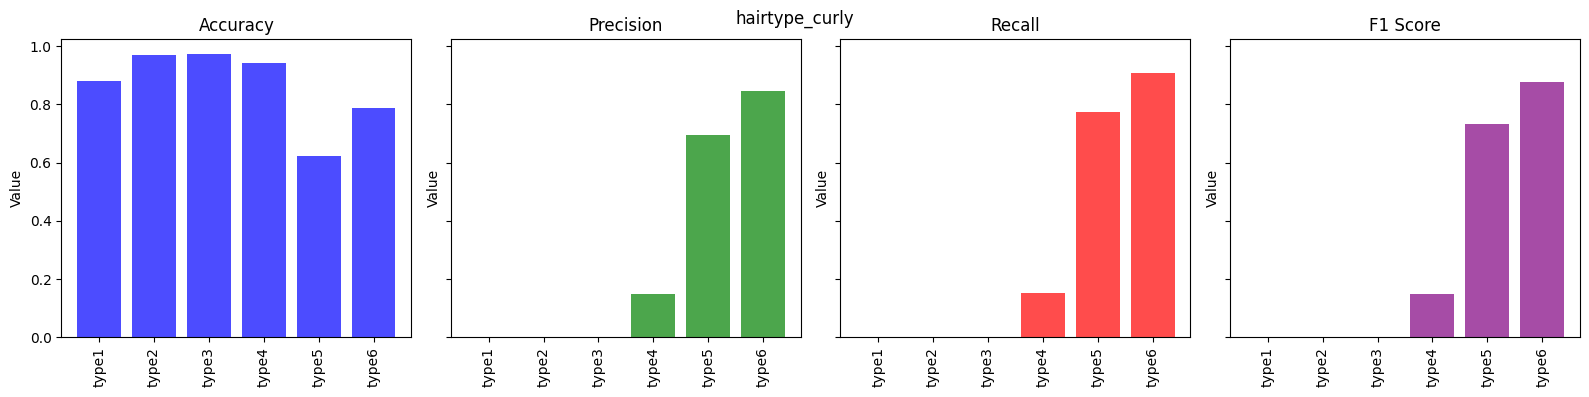

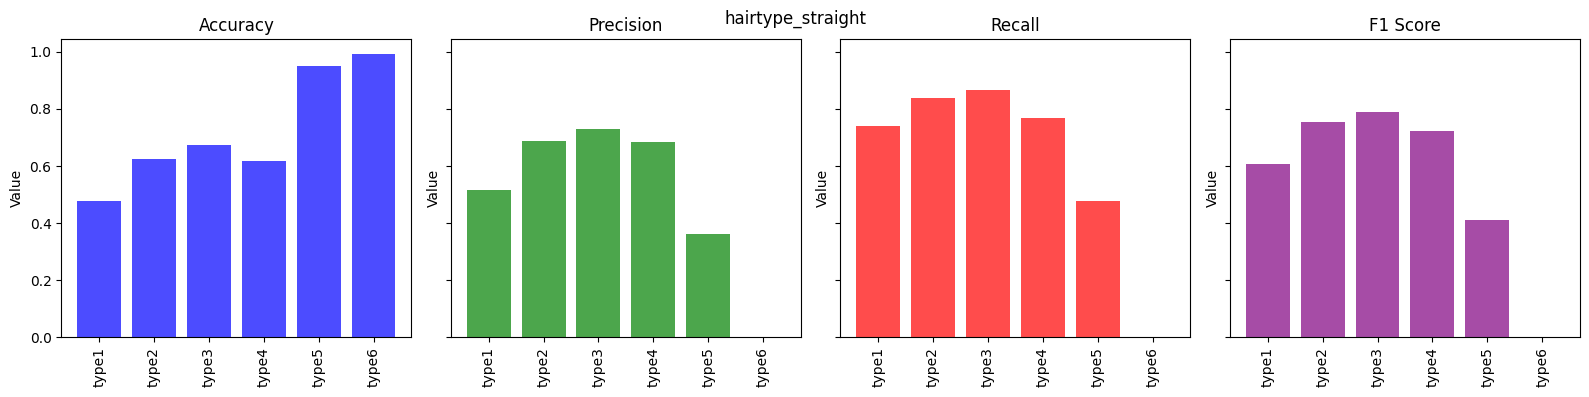

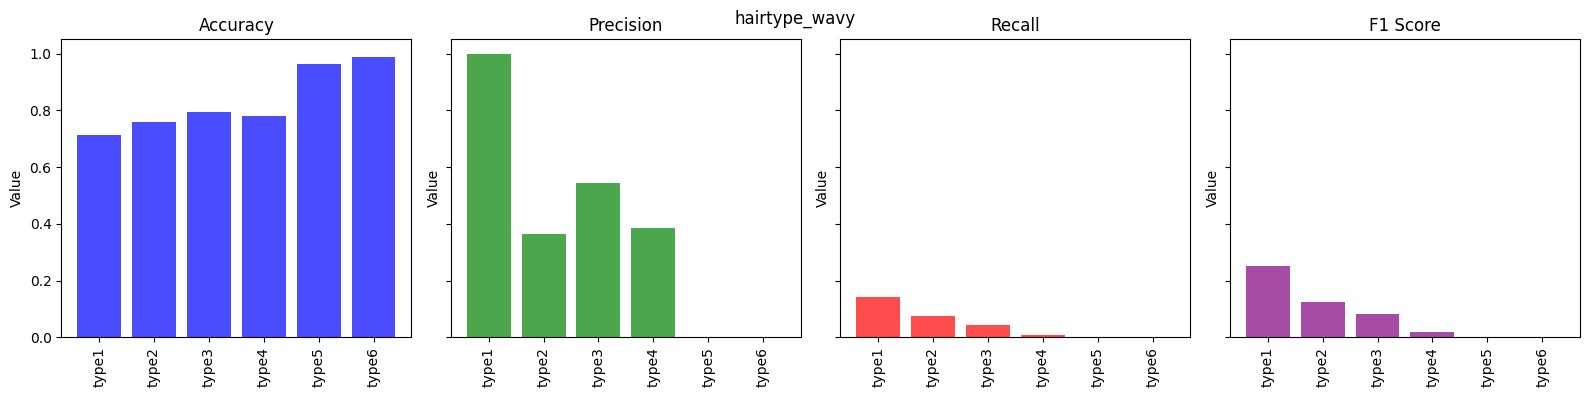

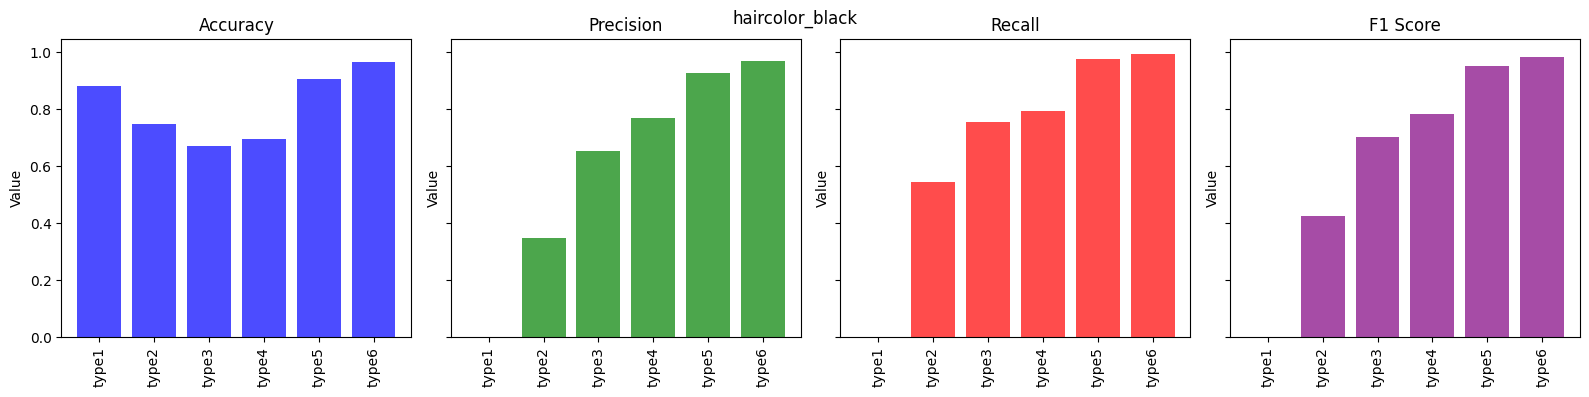

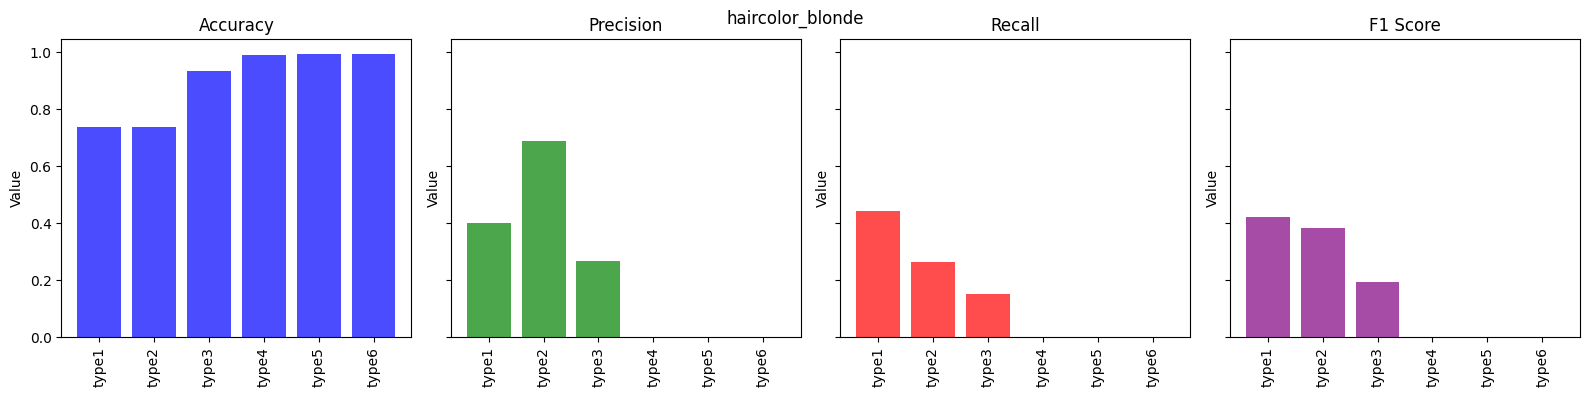

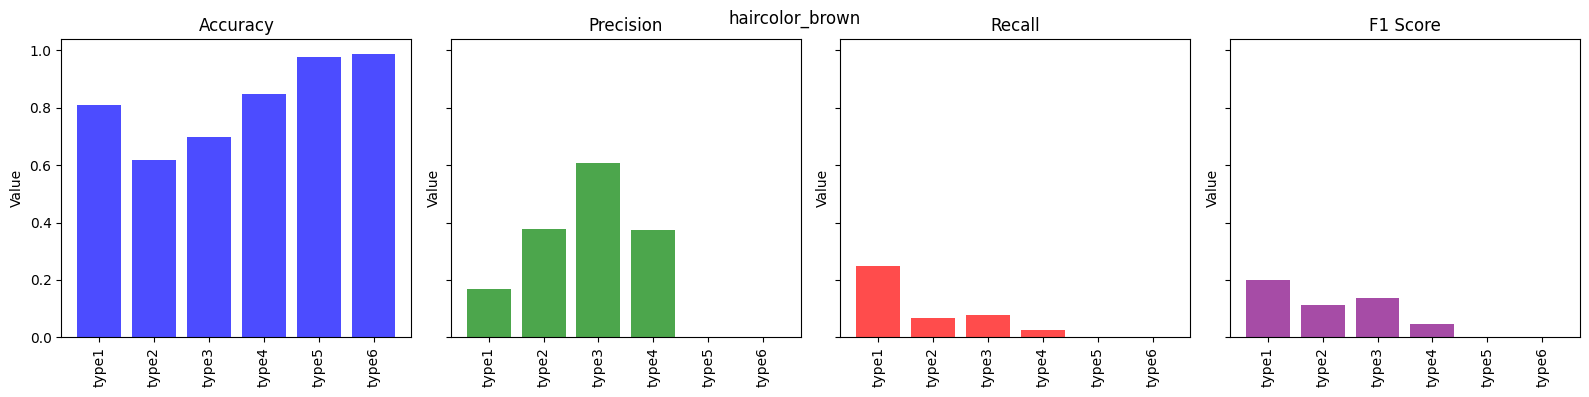

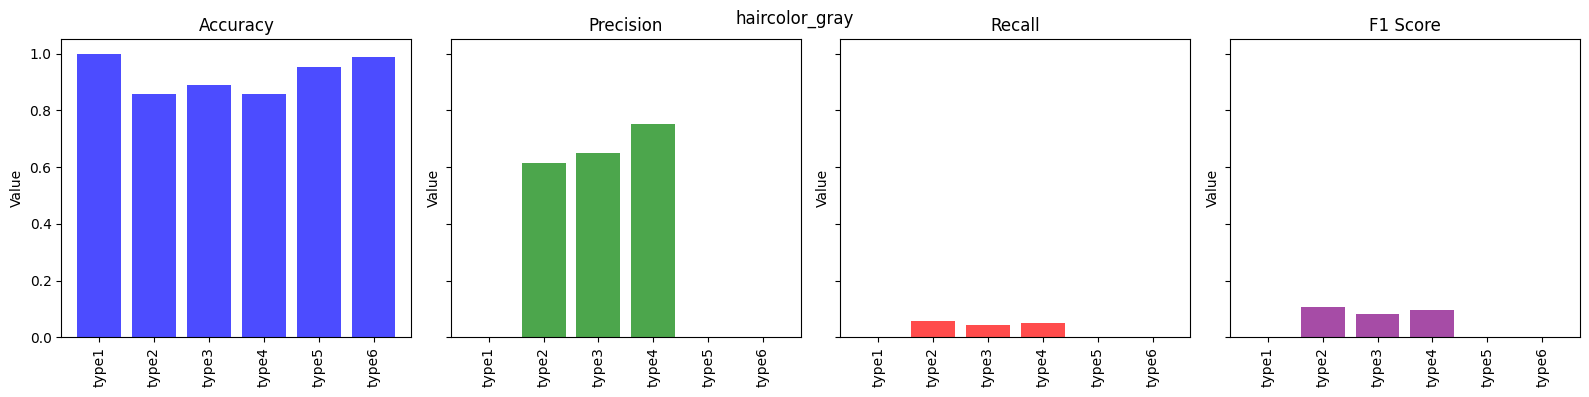

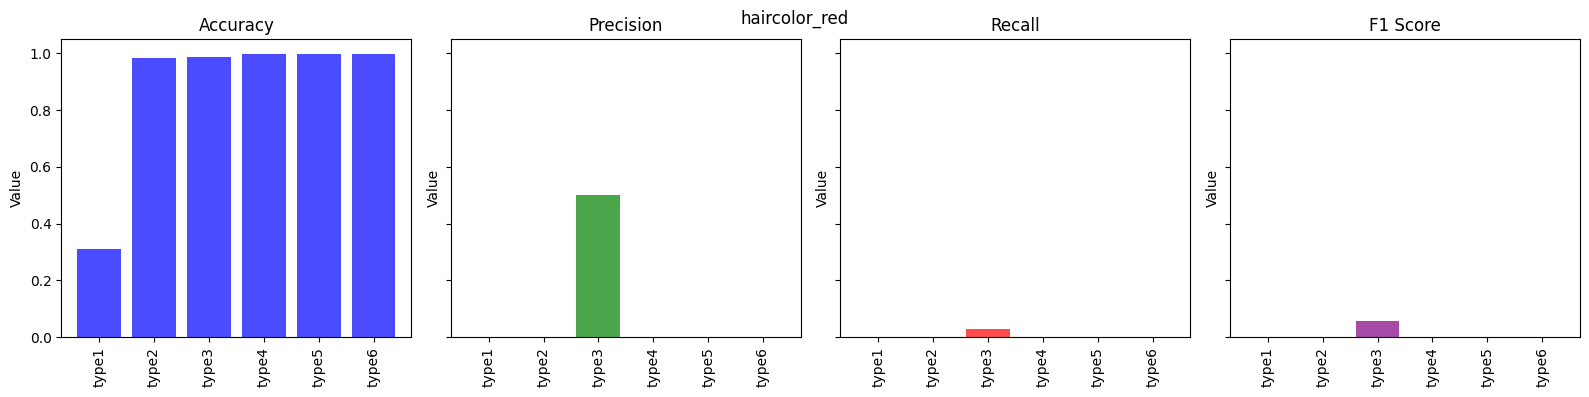

In [77]:
for i, label_name in enumerate(rfw_labels):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
    accuracies, recalls, precisions, f1s = [], [], [], [] 
    for j, skin_type in enumerate(skin_types):
        accuracies.append(baseline_all_metrics['accuracy'][j][i])
        precisions.append(baseline_all_metrics['precision'][j][i])
        recalls.append(baseline_all_metrics['recall'][j][i])
        f1s.append(baseline_all_metrics['f1'][j][i])
        
    axs[0].bar(skin_types, accuracies, color='b', alpha=0.7)
    axs[0].set_title('Accuracy')
    axs[0].set_ylabel('Value')
    axs[0].tick_params(axis='x', rotation=90)

    # Precision plot
    axs[1].bar(skin_types, precisions, color='g', alpha=0.7)
    axs[1].set_title('Precision')
    axs[1].set_ylabel('Value')
    axs[1].tick_params(axis='x', rotation=90)

    # Recall plot
    axs[2].bar(skin_types, recalls, color='r', alpha=0.7)
    axs[2].set_title('Recall')
    axs[2].set_ylabel('Value')
    axs[2].tick_params(axis='x', rotation=90)

    # F1 score plot
    axs[3].bar(skin_types, f1s, color='purple', alpha=0.7)
    axs[3].set_title('F1 Score')
    axs[3].set_ylabel('Value')
    axs[3].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.suptitle(label_name)
    plt.show()
       
    

# Compressed Data

In [15]:
import torch
# model_path = 'models/RFW_numerical_no_skin_resnet18_2024-05-06_16-07-26.pth'
model_path = 'models/RFW_numerical_all_labels_resnet18_2024-05-07_13-45-45.pth'
model = torch.load(model_path)

In [1]:
PROGRESSIVE_ROOT_DIR = '/media/global_data/fair_neural_compression_data/decoded_rfw/progressive_64x64/qres17m'
# MODEL_NAME = 'RFW_numerical_no_skin_resnet18'
lambda_values = [1, 16, 64]
lambda_file_names = [f'q_{l}' for l in lambda_values]
data_rate_values = [1, 3, 6, 9, 12]

In [2]:
import os
COMPRESSED_PROG_PLOT_DIR = 'results/RFW/plots/progressive'
for lambda_file_name in lambda_file_names:
    if not os.path.exists(f'{COMPRESSED_PROG_PLOT_DIR}/{lambda_file_name}'):
        os.makedirs(f'{COMPRESSED_PROG_PLOT_DIR}/{lambda_file_name}')
        for data_rate in data_rate_values:
            if not os.path.exists(f'{COMPRESSED_PROG_PLOT_DIR}/{lambda_file_name}/{data_rate}'):
                os.mkdir(f'{COMPRESSED_PROG_PLOT_DIR}/{lambda_file_name}/{data_rate}')

In [3]:
import os
COMPRESSED_PRED_DIR = 'results/RFW/predictions/progressive'
for lambda_file_name in lambda_file_names:
    if not os.path.exists(f'{COMPRESSED_PRED_DIR}/{lambda_file_name}'):
        os.makedirs(f'{COMPRESSED_PRED_DIR}/{lambda_file_name}')
        for data_rate in data_rate_values:
            if not os.path.exists(f'{COMPRESSED_PRED_DIR}/{lambda_file_name}/{data_rate}'):
                os.mkdir(f'{COMPRESSED_PRED_DIR}/{lambda_file_name}/{data_rate}')

In [8]:
compressed_data_loaders = []
for lambda_file_name in lambda_file_names:
    data_loaders = []
    for data_rate in data_rate_values:
        train_loader, test_loader = create_dataloaders(
            f"{PROGRESSIVE_ROOT_DIR}/{lambda_file_name}/{data_rate}", 
            "/media/global_data/fair_neural_compression_data/datasets/RFW/clean_metadata/numerical_labels.csv"
            , BATCH_SIZE, RATIO, png=True
        )
        data_loaders.append([train_loader, test_loader])
    compressed_data_loaders.append(data_loaders)


In [16]:
for i, lambda_file_name in enumerate(lambda_file_names):
    for data_rate, [train_loader, test_loader] in zip(data_rate_values, compressed_data_loaders[i]):
        save_race_based_predictions(model, 
                                    'RFW_numerical_all_labels_resnet18',
                                    test_loader, 
                                    device, 
                                    f'{COMPRESSED_PRED_DIR}/{lambda_file_name}/{data_rate}'
                                )

prediction_save_dir: results/RFW/predictions/progressive/q_1/1


Getting Predictions:  99%|█████████▉| 251/254 [00:08<00:00, 32.27batch/s]/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Getting Predictions: 100%|██████████| 254/254 [00:08<00:00, 30.83batch/s]


prediction_save_dir: results/RFW/predictions/progressive/q_1/3


Getting Predictions: 100%|██████████| 254/254 [00:08<00:00, 30.70batch/s]


prediction_save_dir: results/RFW/predictions/progressive/q_1/6


Getting Predictions: 100%|██████████| 254/254 [00:08<00:00, 30.24batch/s]


prediction_save_dir: results/RFW/predictions/progressive/q_1/9


Getting Predictions: 100%|██████████| 254/254 [00:08<00:00, 30.00batch/s]


prediction_save_dir: results/RFW/predictions/progressive/q_1/12


Getting Predictions: 100%|██████████| 254/254 [00:08<00:00, 29.96batch/s]


prediction_save_dir: results/RFW/predictions/progressive/q_16/1


Getting Predictions: 100%|██████████| 254/254 [00:08<00:00, 30.31batch/s]


prediction_save_dir: results/RFW/predictions/progressive/q_16/3


Getting Predictions: 100%|██████████| 254/254 [00:08<00:00, 29.76batch/s]


prediction_save_dir: results/RFW/predictions/progressive/q_16/6


Getting Predictions: 100%|██████████| 254/254 [00:08<00:00, 29.39batch/s]


prediction_save_dir: results/RFW/predictions/progressive/q_16/9


Getting Predictions: 100%|██████████| 254/254 [00:08<00:00, 29.65batch/s]


prediction_save_dir: results/RFW/predictions/progressive/q_16/12


Getting Predictions: 100%|██████████| 254/254 [00:08<00:00, 29.88batch/s]


prediction_save_dir: results/RFW/predictions/progressive/q_64/1


Getting Predictions: 100%|██████████| 254/254 [00:08<00:00, 29.92batch/s]


prediction_save_dir: results/RFW/predictions/progressive/q_64/3


Getting Predictions: 100%|██████████| 254/254 [00:08<00:00, 29.74batch/s]


prediction_save_dir: results/RFW/predictions/progressive/q_64/6


Getting Predictions: 100%|██████████| 254/254 [00:08<00:00, 29.56batch/s]


prediction_save_dir: results/RFW/predictions/progressive/q_64/9


Getting Predictions: 100%|██████████| 254/254 [00:08<00:00, 29.38batch/s]


prediction_save_dir: results/RFW/predictions/progressive/q_64/12


Getting Predictions: 100%|██████████| 254/254 [00:08<00:00, 29.79batch/s]


In [28]:
races = ['Indian', 'Asian', 'African', 'Caucasian']
categories = list(all_baseline_results['Indian'].keys())
MODEL_NAME = 'RFW_resnet18'
labels_paths = [f'{MODEL_NAME}_{race}_{category}_labels.pt' for race in races for category in categories]
labels_paths

['RFW_resnet18_Indian_skin_type_labels.pt',
 'RFW_resnet18_Indian_eye_type_labels.pt',
 'RFW_resnet18_Indian_nose_type_labels.pt',
 'RFW_resnet18_Indian_lip_type_labels.pt',
 'RFW_resnet18_Indian_hair_type_labels.pt',
 'RFW_resnet18_Indian_hair_color_labels.pt',
 'RFW_resnet18_Asian_skin_type_labels.pt',
 'RFW_resnet18_Asian_eye_type_labels.pt',
 'RFW_resnet18_Asian_nose_type_labels.pt',
 'RFW_resnet18_Asian_lip_type_labels.pt',
 'RFW_resnet18_Asian_hair_type_labels.pt',
 'RFW_resnet18_Asian_hair_color_labels.pt',
 'RFW_resnet18_African_skin_type_labels.pt',
 'RFW_resnet18_African_eye_type_labels.pt',
 'RFW_resnet18_African_nose_type_labels.pt',
 'RFW_resnet18_African_lip_type_labels.pt',
 'RFW_resnet18_African_hair_type_labels.pt',
 'RFW_resnet18_African_hair_color_labels.pt',
 'RFW_resnet18_Caucasian_skin_type_labels.pt',
 'RFW_resnet18_Caucasian_eye_type_labels.pt',
 'RFW_resnet18_Caucasian_nose_type_labels.pt',
 'RFW_resnet18_Caucasian_lip_type_labels.pt',
 'RFW_resnet18_Caucasian_

In [33]:
import json
with open(f'{PROGRESSIVE_ROOT_DIR}/q_1/1/stats.json', 'r') as json_file:
    data_dict = json.load(json_file)
data_dict


{'name': 'qres17m',
 'lmb': 1,
 'result_dir': 'progressive_64x64',
 'n_keep': 1,
 'results': {'bpp': 0.007461468882967557}}

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = {'acc': {}, 'f1': {}}
for race in races:
    results['acc'][race] = {}
    results['f1'][race] = {}
    for category in categories:
        results['acc'][race][category] = {}
        results['f1'][race][category] = {}
        for lambda_file_name in lambda_file_names:
            results['acc'][race][category][lambda_file_name] = []
            results['f1'][race][category][lambda_file_name] = []
            for data_rate in data_rate_values:
                preds = torch.load(f'{COMPRESSED_PRED_DIR}/{lambda_file_name}/{data_rate}/RFW_numerical_all_labels_resnet18_{race}_{category}_predictions.pt')
                labels = torch.load(f'results/RFW/predictions/RFW_resnet18_{race}_{category}_labels.pt')
                with open(f'{PROGRESSIVE_ROOT_DIR}/{lambda_file_name}/{data_rate}/stats.json', 'r') as json_file:
                    data_dict = json.load(json_file)
                bpp = data_dict['results']['bpp']
                acc = accuracy_score(labels, preds)
                f1 = f1_score(labels, preds, average='weighted')
                results['acc'][race][category][lambda_file_name].append([bpp, acc])
                results['f1'][race][category][lambda_file_name].append([bpp, f1])


In [35]:
results

{'acc': {'Indian': {'skin_type': {'q_1': [[0.007461468882967557,
      0.43523809523809526],
     [0.007463185992273539, 0.4361904761904762],
     [0.06956626530832553, 0.49952380952380954],
     [0.06958269303526542, 0.49952380952380954],
     [0.06958868750578028, 0.49857142857142855]],
    'q_16': [[0.009580553046133616, 0.43047619047619046],
     [0.010960159181805795, 0.36952380952380953],
     [0.1324323349823532, 0.5247619047619048],
     [0.20469056523175458, 0.5514285714285714],
     [0.3665034044437182, 0.6004761904761905]],
    'q_64': [[0.010865931109864174, 0.4723809523809524],
     [0.01401326913838128, 0.40904761904761905],
     [0.20318071834509452, 0.5619047619047619],
     [0.4595163508693375, 0.6152380952380953],
     [0.6997467670037869, 0.65]]},
   'eye_type': {'q_1': [[0.007461468882967557, 0.5480952380952381],
     [0.007463185992273539, 0.549047619047619],
     [0.06956626530832553, 0.5333333333333333],
     [0.06958269303526542, 0.5338095238095238],
     [0.069

In [52]:
all_baseline_results 

{'Indian': {'eye_type': {'accuracy': 0.6228571428571429,
   'precision': 0.6220528228983959,
   'recall': 0.6228571428571429,
   'f1': 0.61295968818248},
  'nose_type': {'accuracy': 0.6647619047619048,
   'precision': 0.6648913544259104,
   'recall': 0.6647619047619048,
   'f1': 0.6648260279225962},
  'lip_type': {'accuracy': 0.9709523809523809,
   'precision': 0.9909522009945086,
   'recall': 0.9709523809523809,
   'f1': 0.9807144967406025},
  'hair_type': {'accuracy': 0.6090476190476191,
   'precision': 0.3925293426060618,
   'recall': 0.6090476190476191,
   'f1': 0.47732233549910036},
  'hair_color': {'accuracy': 0.6480952380952381,
   'precision': 0.5048275938858453,
   'recall': 0.6480952380952381,
   'f1': 0.5630329474184896}},
 'Caucasian': {'eye_type': {'accuracy': 0.8379466532460996,
   'precision': 0.81299970928099,
   'recall': 0.8379466532460996,
   'f1': 0.8235315040748279},
  'nose_type': {'accuracy': 0.6477101157523906,
   'precision': 0.6471275311848452,
   'recall': 0.

In [32]:
results['f1'][race][category]

{'q_1': []}

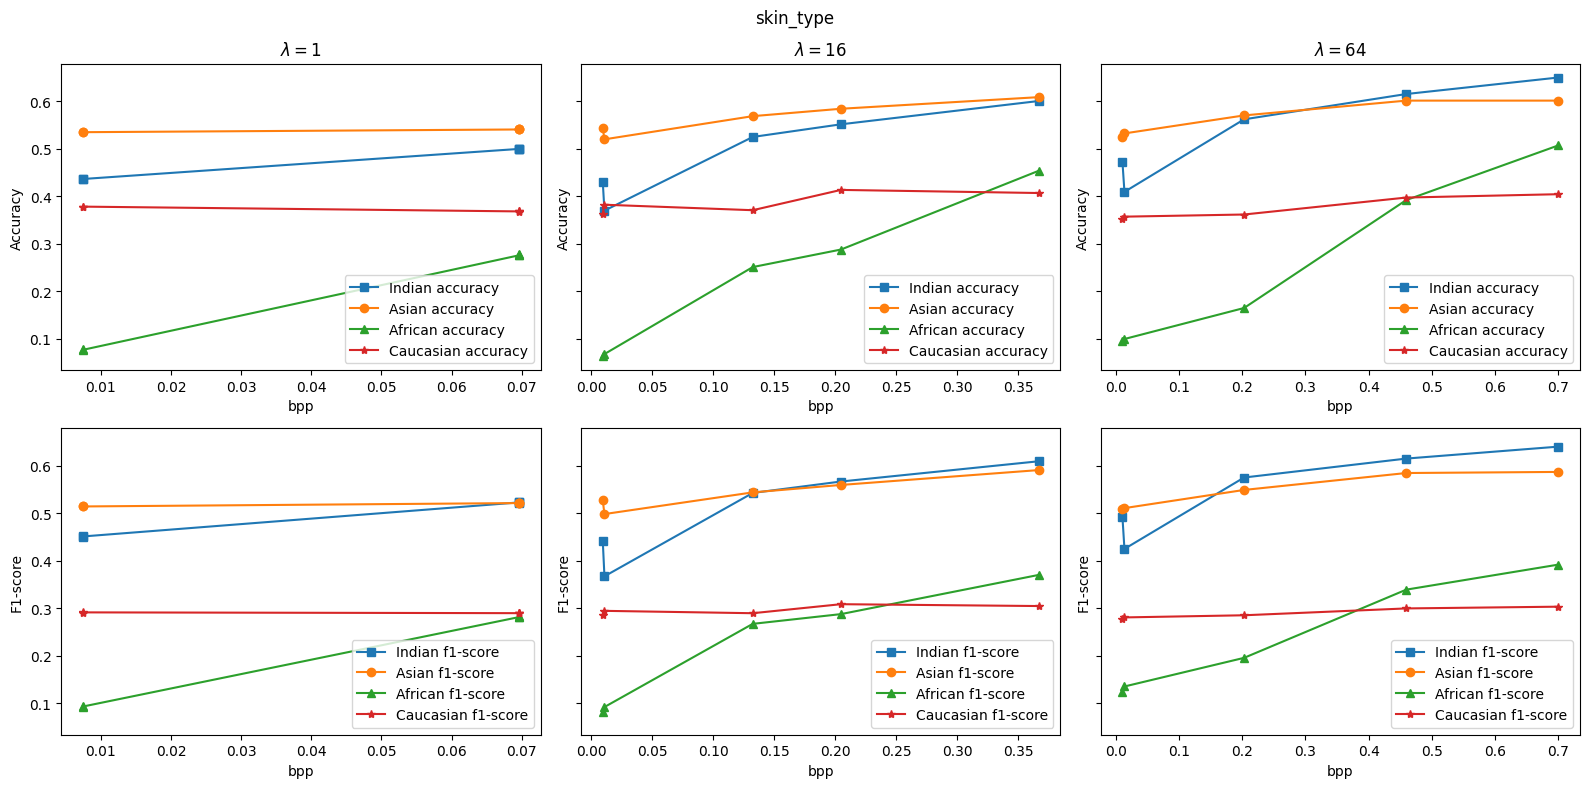

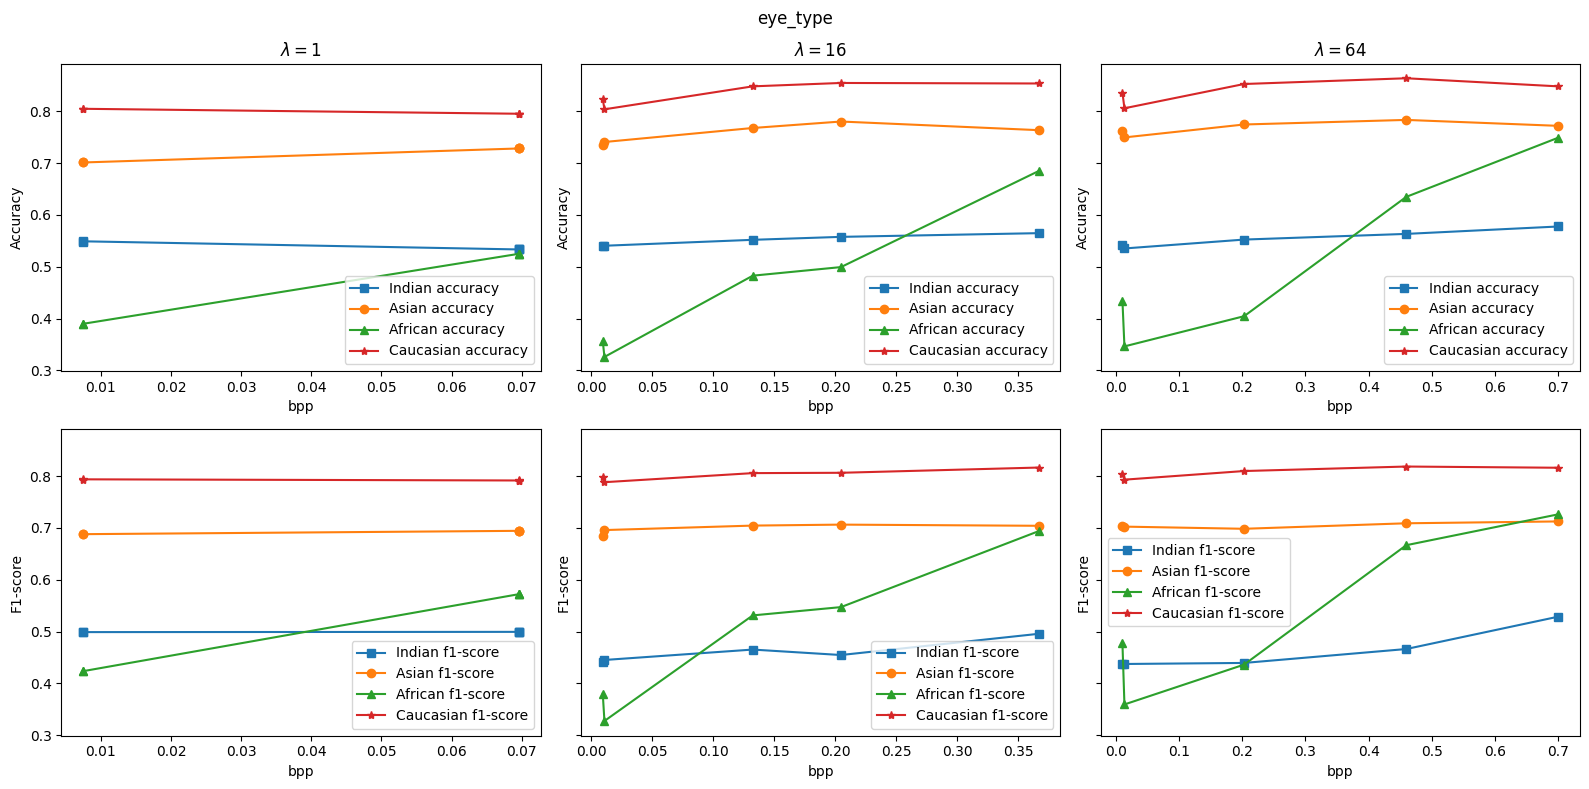

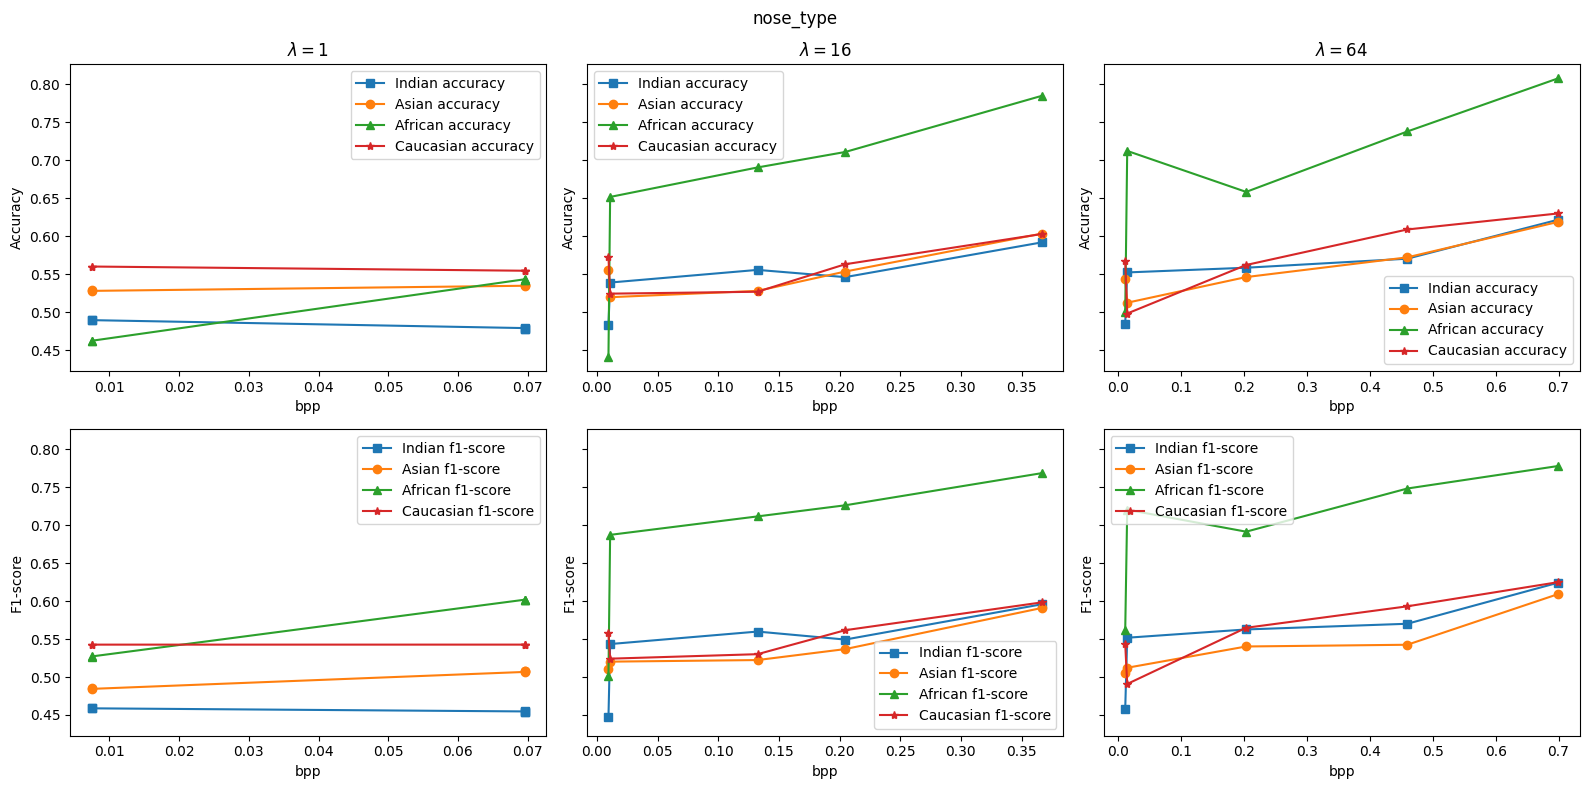

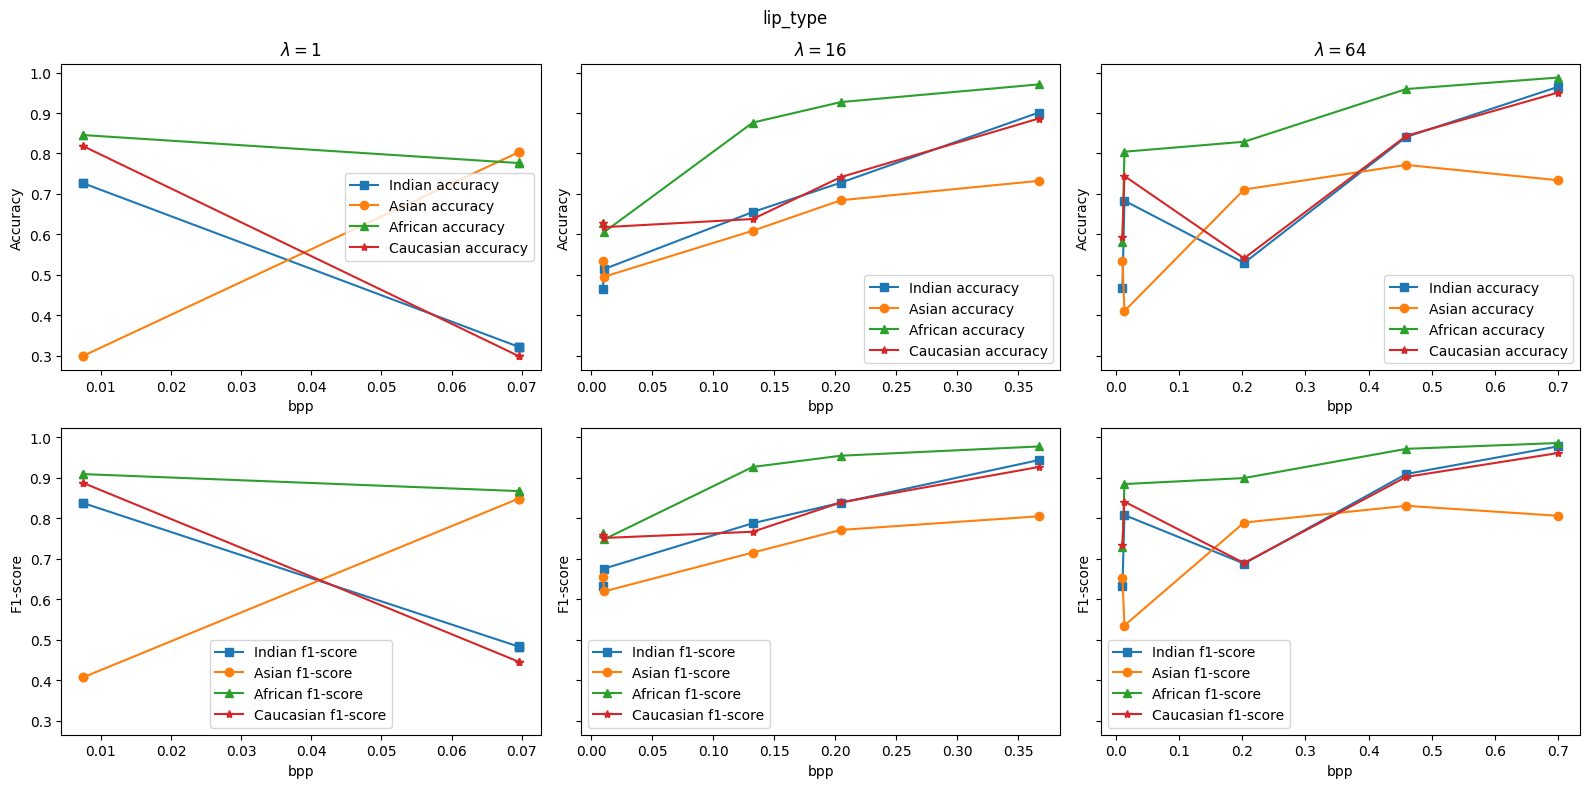

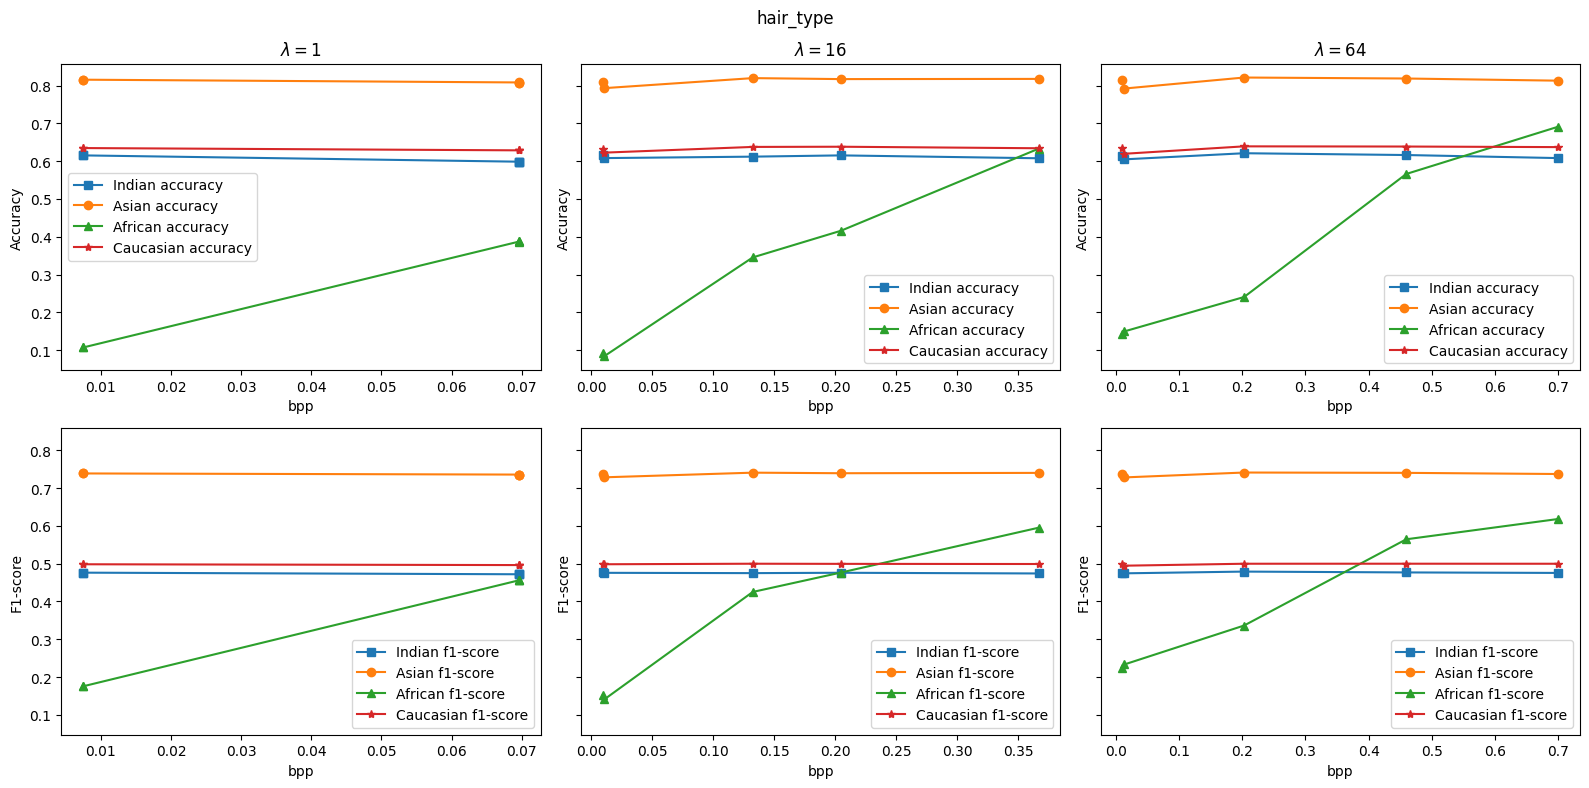

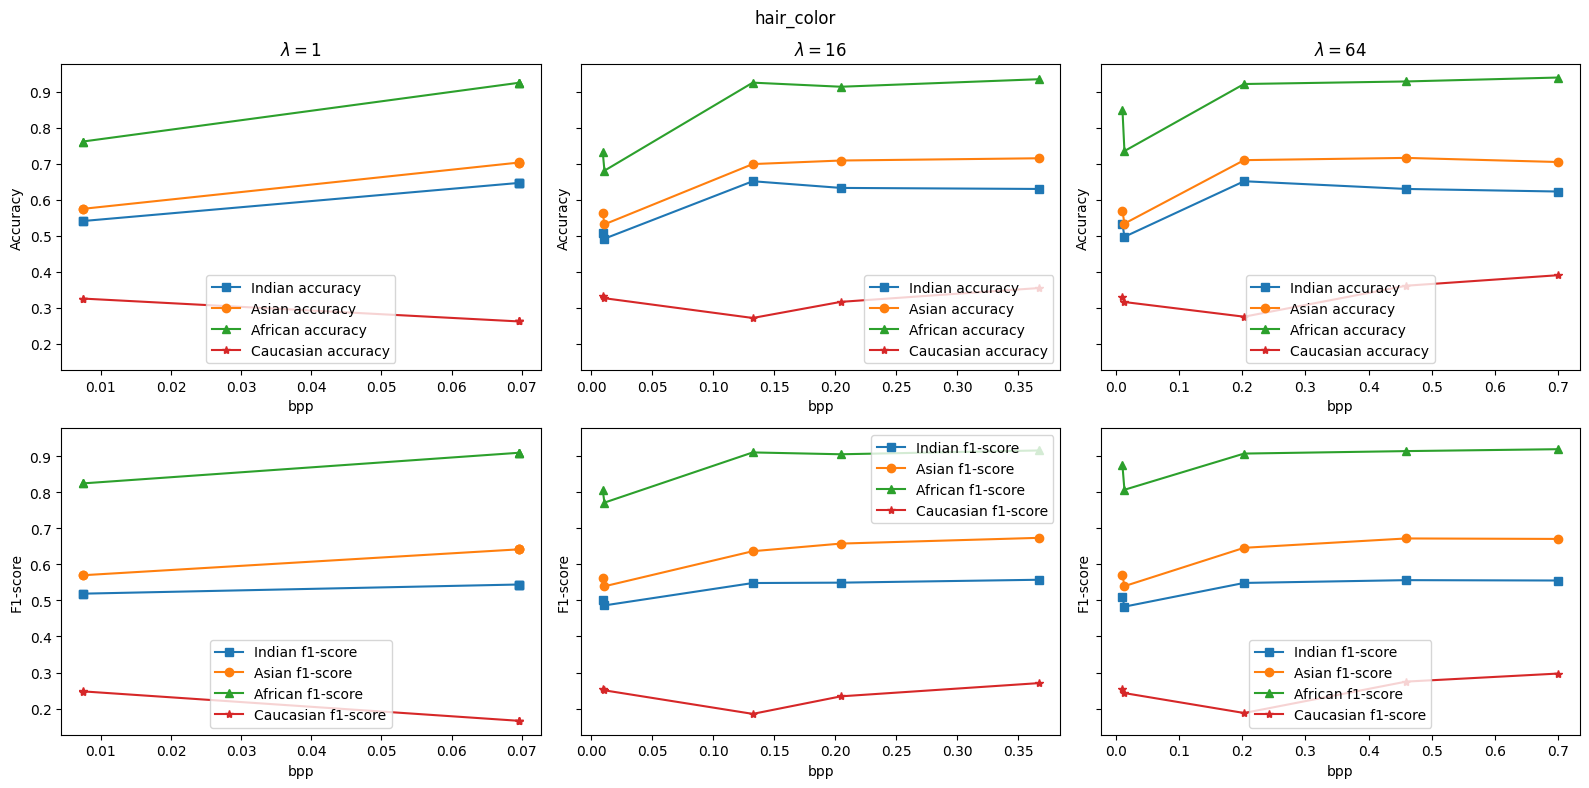

In [38]:
import matplotlib.pyplot as plt
import numpy as np

all_metrics_plot_path = 'results/RFW/plots/progressive'
all_male_data, all_female_data = {}, {}
race_markers = ['s', 'o', '^', '*']
for i, category in enumerate(categories):
    fig, axes = plt.subplots(2, len(lambda_file_names), figsize=(16, 8), sharey=True)
    for j, lambda_file_name in enumerate(lambda_file_names):
        for race, race_marker in zip(races, race_markers):
            race_accuracies = []
            race_f1_scores = []
            bpps = []
            for k, data_rate in enumerate(data_rate_values):
                race_accuracies.append(results['acc'][race][category][lambda_file_name][k][1])
                race_f1_scores.append(results['f1'][race][category][lambda_file_name][k][1])
                bpps.append(results['f1'][race][category][lambda_file_name][k][0])
            axes[0][j].plot(bpps, race_accuracies, marker=race_marker, label=f'{race} accuracy')
            axes[1][j].plot(bpps, race_f1_scores, marker=race_marker, label=f'{race} f1-score')
            axes[0][j].set_title(fr'$\lambda = {lambda_values[j]}$')
            axes[0][j].set_xlabel('bpp')
            axes[0][j].set_ylabel('Accuracy')
            axes[1][j].set_xlabel('bpp')
            axes[1][j].set_ylabel('F1-score')
            # axes[0][j].axhline(y=all_baseline_results[race][category]['accuracy'], linestyle='--', label=f'Baseline accuracy {race} - {category}')
            # axes[0][j].axhline(y=all_baseline_results[race][category]['f1'], linestyle='--', label=f'Baseline f1 {race} - {category}')
            
            axes[0][j].legend()
            axes[1][j].legend()
    plt.suptitle(category)
    plt.tight_layout()
    plt.savefig(f'{all_metrics_plot_path}/{category}.png')
    plt.show()
    # for j, lambda_file_name in enumerate(lambda_file_names):
    #     data_male['accuracy'][j] = []
    #     data_female['accuracy'][j] = []
    #     data_male['f1'][j] = []
    #     data_female['f1'][j] = []
    #     for data_rate in data_rates:
    #         data_male['accuracy'][j].append(results['accuracy'][lambda_file_name][data_rate][0][i])
    #         data_female['accuracy'][j].append(results['accuracy'][lambda_file_name][data_rate][1][i])
            
    #         data_male['f1'][j].append(results['f1'][lambda_file_name][data_rate][0][i])
    #         data_female['f1'][j].append(results['f1'][lambda_file_name][data_rate][1][i])
            
        
    #     data_male['accuracy'][j] = np.array(data_male['accuracy'][j])
    #     data_male['f1'][j] = np.array(data_male['f1'][j])
    
    #     data_female['accuracy'][j] = np.array(data_female['accuracy'][j])
    #     data_female['f1'][j] = np.array(data_female['f1'][j])
    
    # for j, lambda_file_name in enumerate(lambda_file_names):
    #     axes[0][j].plot(data_rates, data_male['accuracy'][j], marker='o', label='Male Accuracy')
    #     axes[0][j].plot(data_rates, data_female['accuracy'][j], marker='o', label='Female Accuracy')
    #     axes[0][j].set_title(fr'$\lambda$ = {lambda_rates[j]}')
    #     axes[0][j].set_xlabel('Data Rates')
    #     axes[0][j].set_ylabel('Accuracy')
    #     axes[0][j].axhline(y=baseline_accuracy_male[i], color='b', linestyle='--', label='Baseline Accuracy Male')
    #     axes[0][j].axhline(y=baseline_accuracy_female[i], color='r', linestyle='--', label='Baseline Accuracy Female')
    
    #     axes[1][j].plot(data_rates, data_male['f1'][j], marker='o', label='Male F1-score')
    #     axes[1][j].plot(data_rates, data_female['f1'][j], marker='o', label='Female F1-score')
    #     axes[1][j].set_title(fr'$\lambda$ = {lambda_rates[j]}')
    #     axes[1][j].set_xlabel('Data Rates')
    #     axes[1][j].set_ylabel('F1-score')
    #     axes[1][j].axhline(y=baseline_f1_male[i], color='b', linestyle='--', label='Baseline F1-score Male')
    #     axes[1][j].axhline(y=baseline_f1_female[i], color='r', linestyle='--', label='Baseline F1-score Female')
    
    #     axes[0][j].legend()
    #     axes[1][j].legend()
    
    # plt.suptitle(label)
    # plt.tight_layout()
    # # plt.savefig(f'{all_metrics_plot_path}/{label}.png')
    # plt.show()


In [23]:
list(all_baseline_results['Indian'].keys())

['eye_type', 'nose_type', 'lip_type', 'hair_type', 'hair_color']